**Forming the whole dataset**

In [ ]:
import pandas as pd

# Load CSVs
median_masked = pd.read_csv('/content/merged_energy_median_masked_timeseries.csv')
maximum = pd.read_csv('/content/merged_energy_timeseries_maximum.csv')
minimum = pd.read_csv('/content/merged_energy_timeseries_minimum.csv')
median = pd.read_csv('/content/merged_energy_timeseries_median .csv')

# Define years
years = list(range(2013, 2022))  # 2013 to 2021

# Initialize result DataFrame with Country
result = pd.DataFrame()
result['Country'] = median['Country']

# Helper function to extract specific columns from a DataFrame
def get_columns(df, value_type, label):
    temp = pd.DataFrame()
    temp['Country'] = df['Country']
    for year in years:
        col = f"{year}_{value_type}"
        if col in df.columns:
            temp[f"{year}_{label}"] = df[col]
        else:
            temp[f"{year}_{label}"] = None
    return temp.drop(columns='Country')  # Avoid duplicating 'Country'

# Build final DataFrame in the required column order
median_data = get_columns(median, 'median', 'median')
masked_data = get_columns(median_masked, 'median_masked', 'median_masked')
min_data = get_columns(minimum, 'minimum', 'minimum')
max_data = get_columns(maximum, 'maximum', 'maximum')
energy_data = get_columns(median_masked, 'energy_consumption', 'energy_consumption')

# Concatenate all pieces
final_df = pd.concat([result, median_data, masked_data, min_data, max_data, energy_data], axis=1)

# Save to Excel
output_path = '/content/structured_combined_data.xlsx'
final_df.to_excel(output_path, index=False)

print(f"Structured Excel file saved at: {output_path}")


Structured Excel file saved at: /content/structured_combined_data_1.xlsx


Making the Training Data

In [ ]:
import pandas as pd

# Load CSVs
median_masked = pd.read_csv('/content/merged_energy_median_masked_timeseries.csv')
maximum = pd.read_csv('/content/merged_energy_timeseries_maximum.csv')
minimum = pd.read_csv('/content/merged_energy_timeseries_minimum.csv')
median = pd.read_csv('/content/merged_energy_timeseries_median .csv')

# Define years
years = list(range(2013, 2021))  # 2013 to 2021

# Initialize result DataFrame with Country
result = pd.DataFrame()
result['Country'] = median['Country']

# Helper function to extract specific columns from a DataFrame
def get_columns(df, value_type, label):
    temp = pd.DataFrame()
    temp['Country'] = df['Country']
    for year in years:
        col = f"{year}_{value_type}"
        if col in df.columns:
            temp[f"{year}_{label}"] = df[col]
        else:
            temp[f"{year}_{label}"] = None
    return temp.drop(columns='Country')  # Avoid duplicating 'Country'

# Build final DataFrame in the required column order
median_data = get_columns(median, 'median', 'median')
masked_data = get_columns(median_masked, 'median_masked', 'median_masked')
min_data = get_columns(minimum, 'minimum', 'minimum')
max_data = get_columns(maximum, 'maximum', 'maximum')
energy_data = get_columns(median_masked, 'energy_consumption', 'energy_consumption')

# Concatenate all pieces
final_df = pd.concat([result, median_data, masked_data, min_data, max_data, energy_data], axis=1)

# Save to Excel
output_path = '/content/structured_combined_data_train.xlsx'
final_df.to_excel(output_path, index=False)

print(f"Structured Excel file saved at: {output_path}")


Structured Excel file saved at: /content/structured_combined_data_train.xlsx


**Displaying the data**

In [ ]:
# Display the first few rows of the structured DataFrame
print(final_df.head())


       Country   2013_median   2014_median   2015_median   2016_median  \
0  Afghanistan  5.570191e+05  5.604143e+05  4.444421e+05  3.096172e+05   
1      Albania  9.673312e+04  9.634586e+04  8.195824e+04  7.798445e+04   
2      Algeria  3.802680e+06  4.114501e+06  4.136905e+06  4.020184e+06   
3       Angola  2.864696e+05  2.029127e+05  9.418661e+04  1.579889e+05   
4    Argentina  4.341170e+06  4.323284e+06  4.201482e+06  4.033337e+06   

    2017_median   2018_median   2019_median  2020_median  2013_median_masked  \
0  1.041428e+06  8.997276e+05  8.800933e+05  1059025.649        8.853925e+04   
1  1.140656e+05  1.120838e+05  1.204866e+05   134725.056        7.648594e+04   
2  5.921239e+06  5.588510e+06  5.351434e+06  6041095.442        2.553885e+06   
3  1.198673e+06  1.107829e+06  8.307652e+05  1252607.031        1.710788e+05   
4  6.432468e+06  6.422812e+06  6.097394e+06  7001255.510        3.241088e+06   

   ...  2019_maximum  2020_maximum  2013_energy_consumption  \
0  ...  1.2

**ARIMA Model without log transformation**

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the merged dataset
df = pd.read_excel('/content/structured_combined_data_train.xlsx')

# Get list of countries
countries = df['Country'].unique()

# Forecast results will be saved here
forecast_results = []

# Define years used for training
years = [str(y) for y in range(2013, 2021)]  # 2013 to 2020

# Loop through each country
for country in countries:
    row = df[df['Country'] == country]

    # Extract target variable (energy consumption)
    y = pd.Series([row[f"{year}_energy_consumption"].values[0] for year in years], index=years)

    # Prepare exogenous features
    exog_data = {
        'median': [row[f"{year}_median"].values[0] for year in years],
        'median_masked': [row[f"{year}_median_masked"].values[0] for year in years],
        'minimum': [row[f"{year}_minimum"].values[0] for year in years],
        'maximum': [row[f"{year}_maximum"].values[0] for year in years],
    }
    exog = pd.DataFrame(exog_data, index=years)

    # Fit SARIMAX model
    model = SARIMAX(y, exog=exog, order=(1,1,1))
    model_fit = model.fit(disp=False)

    # Prepare exog for 2021 using last known values (2020)
    last_exog = exog.iloc[-1:].copy()
    last_exog.index = ['2021']

    # Forecast energy consumption for 2021
    forecast = model_fit.forecast(steps=1, exog=last_exog)

    forecast_results.append({'Country': country, 'Forecast_2021': forecast[0]})

# Create DataFrame and save
forecast_df = pd.DataFrame(forecast_results)
forecast_df.to_excel('/content/forecast_energy_2021.xlsx', index=False)

# Display result
print(forecast_df)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-6-1af408334fe1>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_results.append({'Country': country, 'Forecast_2021': forecast[0]})
/usr/local/lib/pyth

               Country  Forecast_2021
0          Afghanistan      27.302779
1              Albania      32.263568
2              Algeria     648.898800
3               Angola     117.907630
4            Argentina     869.828550
..                 ...            ...
175              Yemen      35.254242
176             Zambia      59.172483
177           Zimbabwe      41.996760
178  antigua & barbuda       2.574913
179     czech republic     426.303277

[180 rows x 2 columns]


<ipython-input-6-1af408334fe1>:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast_results.append({'Country': country, 'Forecast_2021': forecast[0]})


**Calculating the R2 score**

In [ ]:
import pandas as pd
from sklearn.metrics import r2_score

# Load actual 2021 data
actual_df = pd.read_excel('/content/2021_Energy_data.xlsx')  # Or whatever your path is
# Ensure it contains: 'Country' and '2021_energy_consumption'

# Load forecasted 2021 values from your SARIMAX output
forecast_df = pd.read_excel('/content/forecast_energy_2021.xlsx')  # Contains: 'Country' and 'Forecast_2021'

# Merge both DataFrames on 'Country'
merged_df = pd.merge(actual_df[['Country', '2021_energy_consumption']], forecast_df, on='Country')

# Extract the true and predicted values
y_true = merged_df['2021_energy_consumption']
y_pred = merged_df['Forecast_2021']

# Calculate R² Score
r2 = r2_score(y_true, y_pred)
print(f"R² Score for 2021 Energy Forecast: {r2:.4f}")


R² Score for 2021 Energy Forecast: 0.9980


**Ploting the actual vs predicted data**

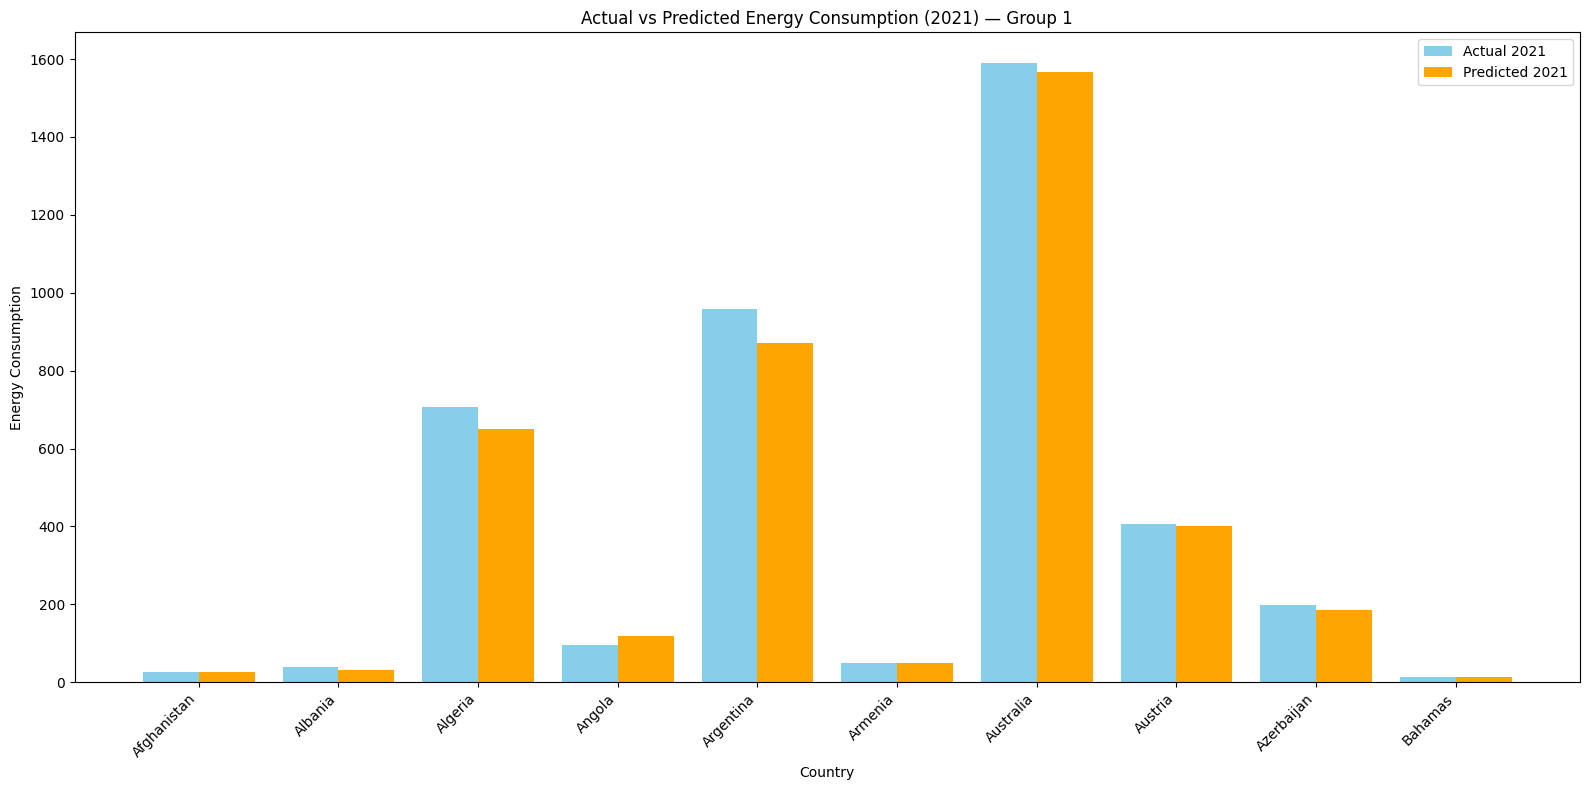

Plot saved to: /content/energy_comparison_2021_group_1.png


<Figure size 640x480 with 0 Axes>

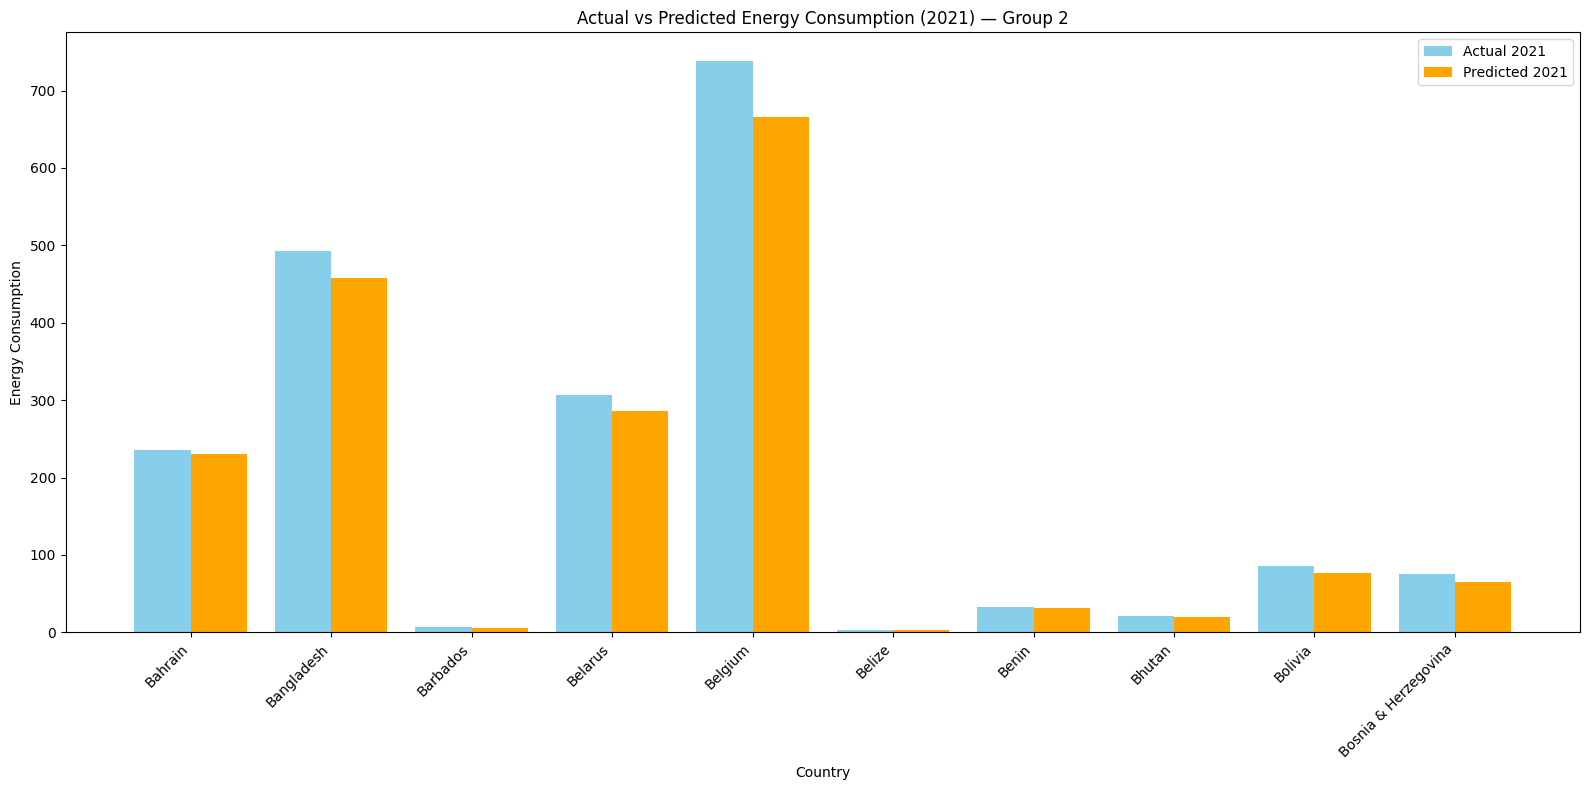

Plot saved to: /content/energy_comparison_2021_group_2.png


<Figure size 640x480 with 0 Axes>

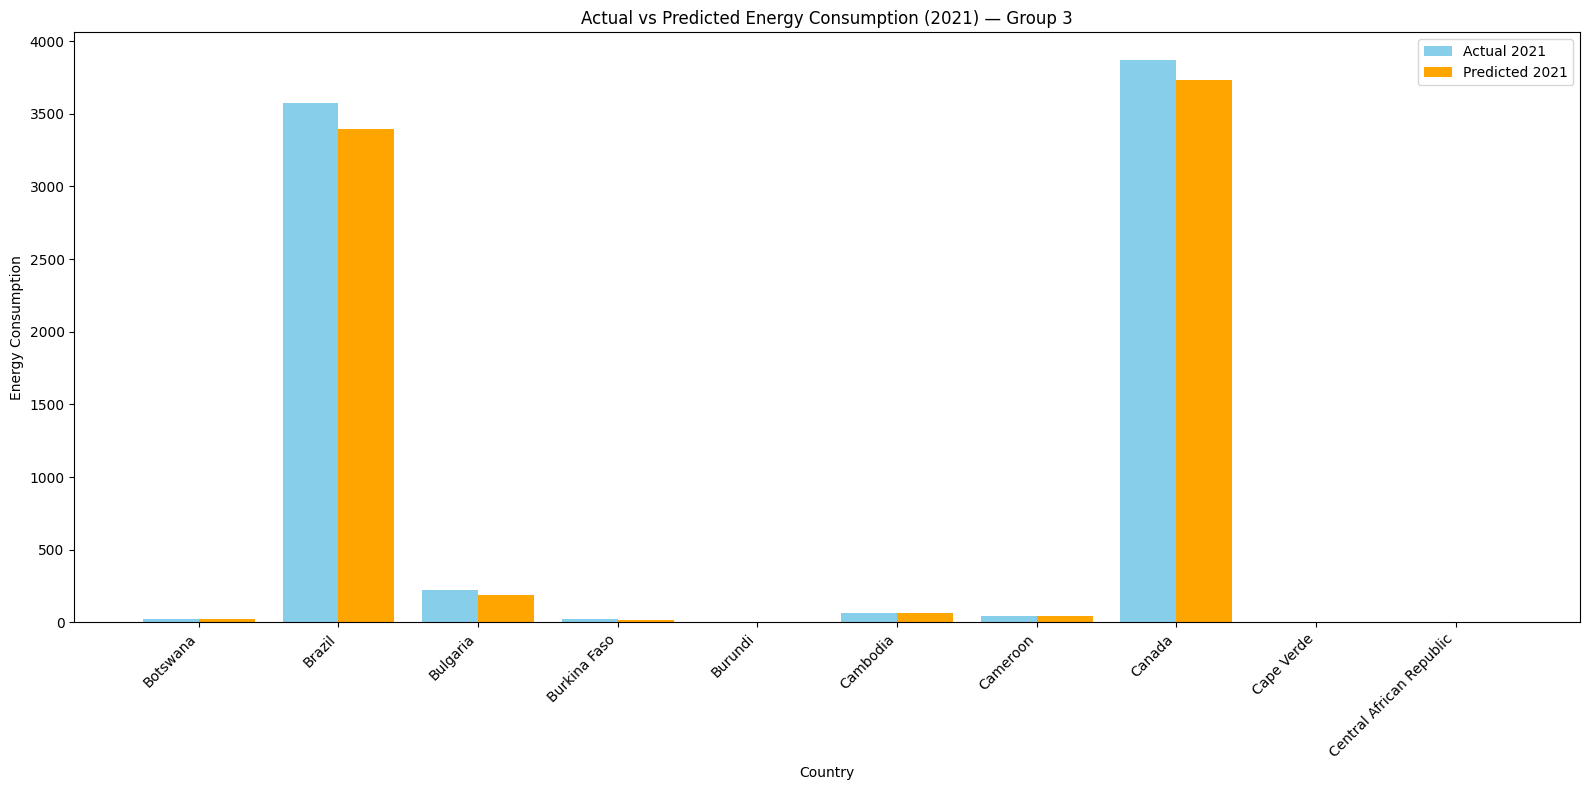

Plot saved to: /content/energy_comparison_2021_group_3.png


<Figure size 640x480 with 0 Axes>

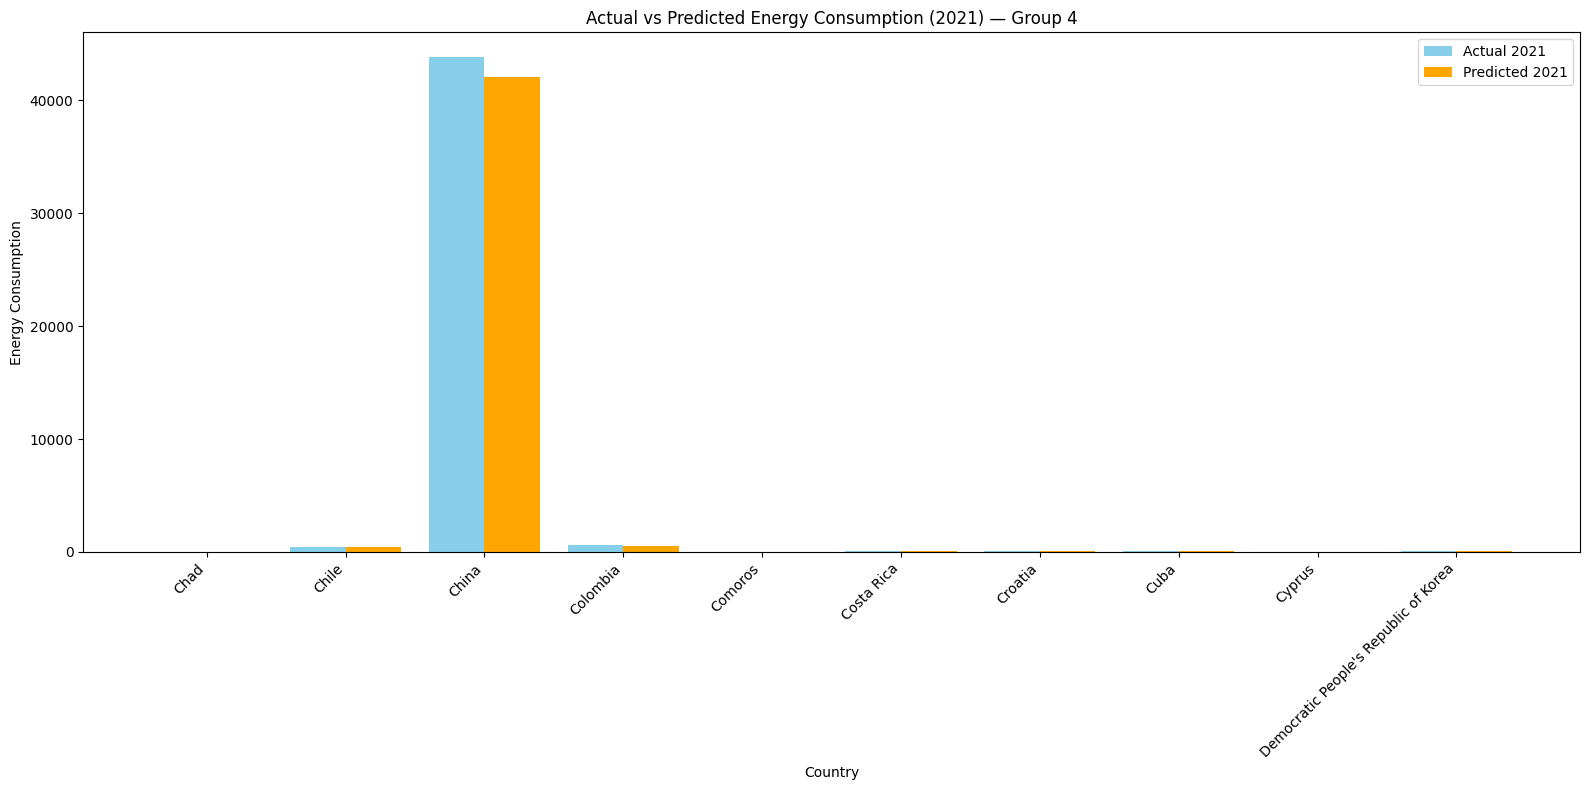

Plot saved to: /content/energy_comparison_2021_group_4.png


<Figure size 640x480 with 0 Axes>

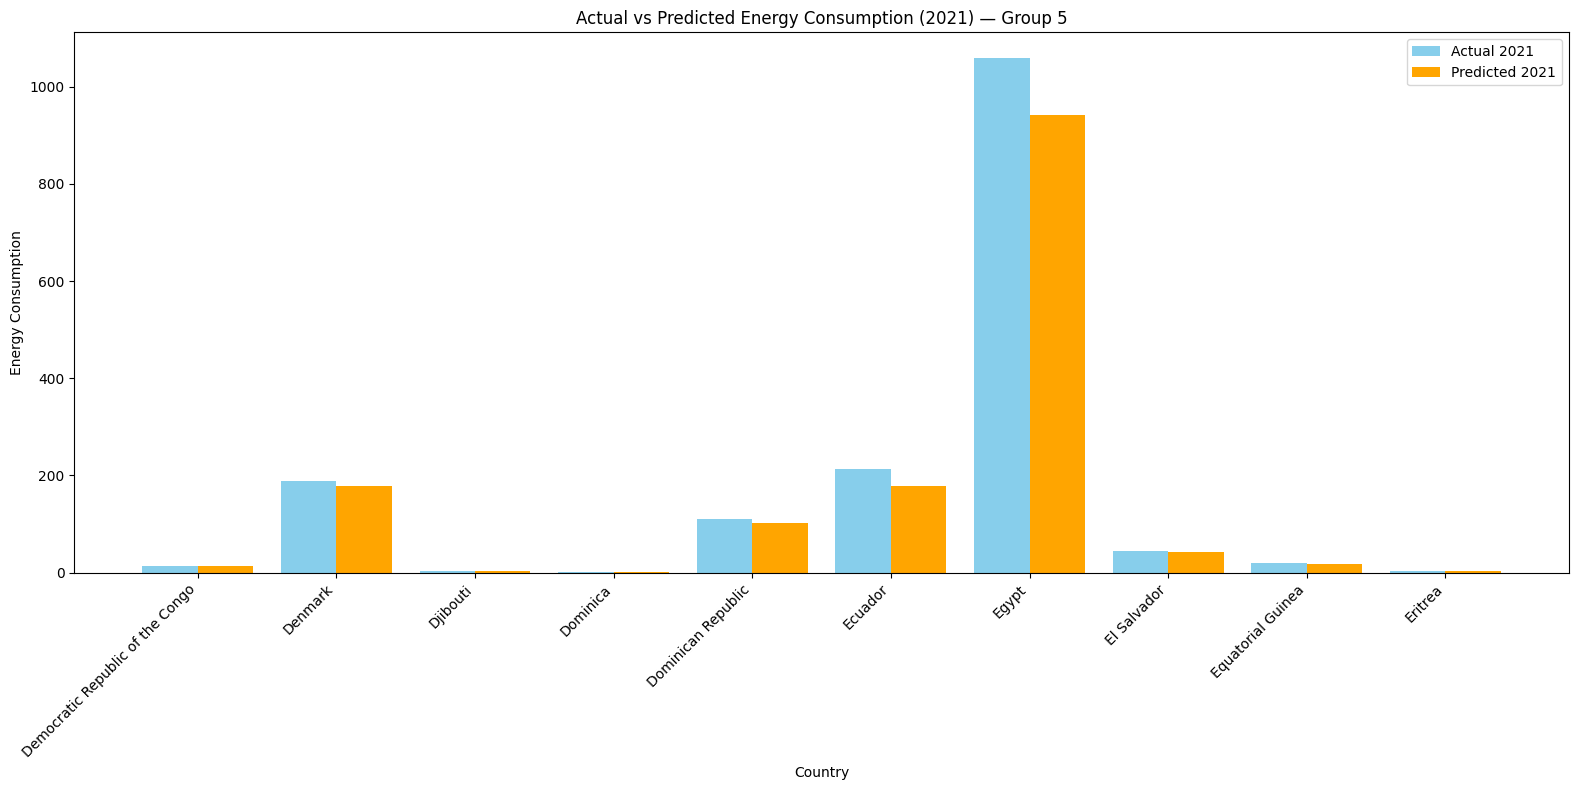

Plot saved to: /content/energy_comparison_2021_group_5.png


<Figure size 640x480 with 0 Axes>

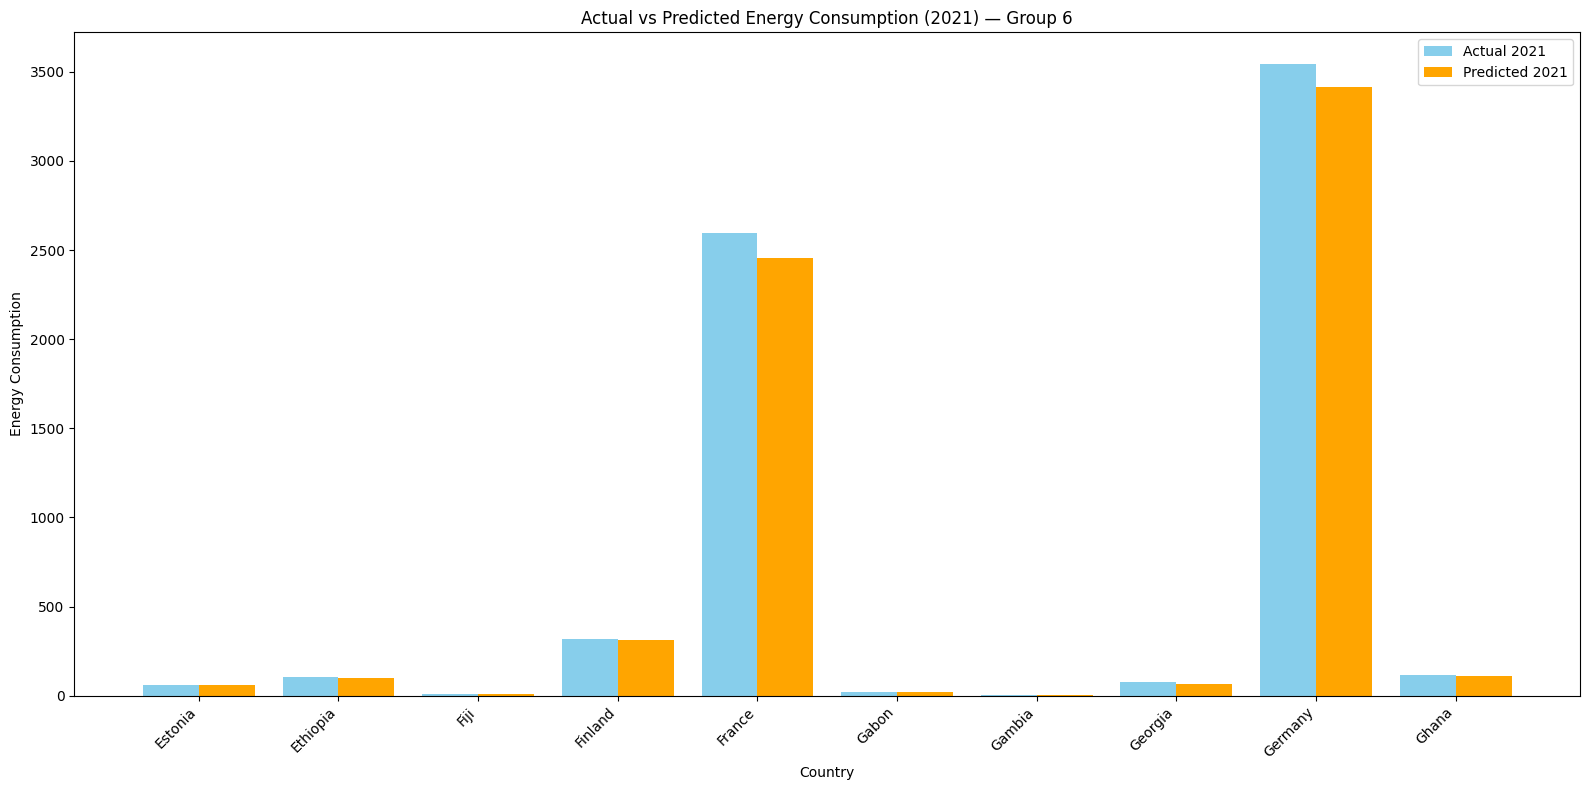

Plot saved to: /content/energy_comparison_2021_group_6.png


<Figure size 640x480 with 0 Axes>

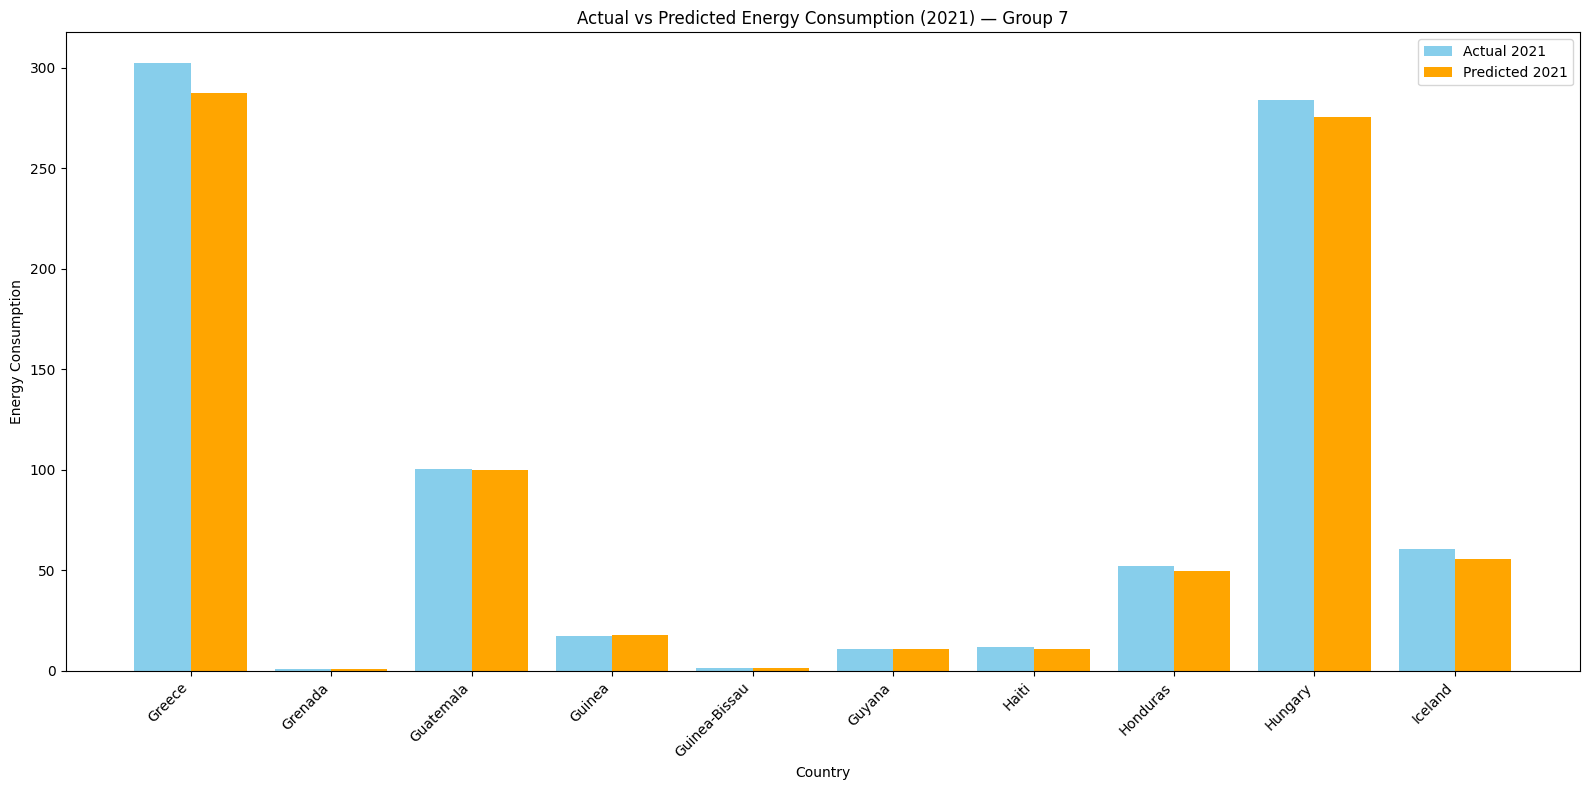

Plot saved to: /content/energy_comparison_2021_group_7.png


<Figure size 640x480 with 0 Axes>

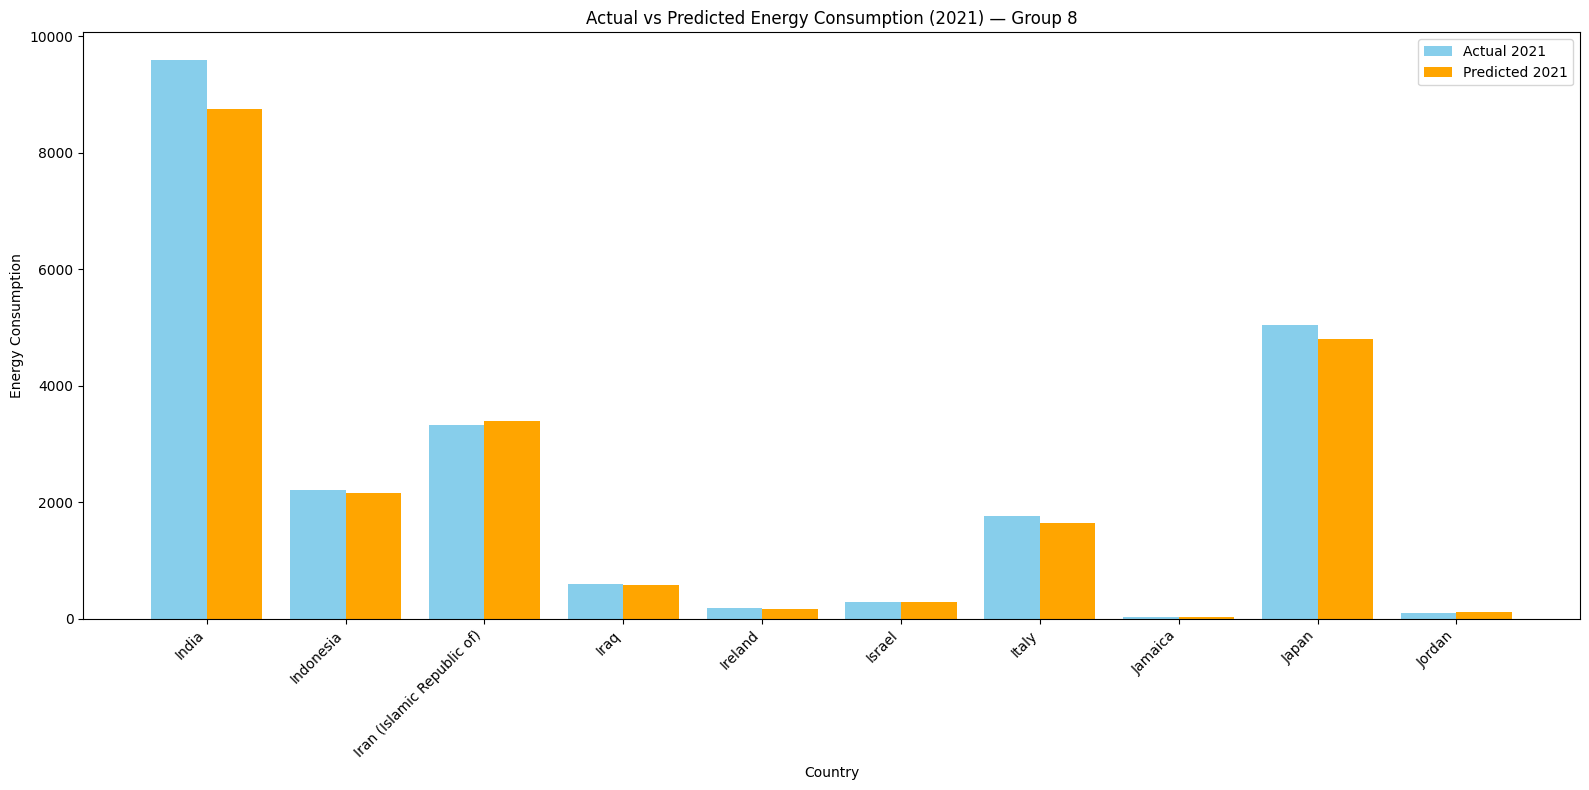

Plot saved to: /content/energy_comparison_2021_group_8.png


<Figure size 640x480 with 0 Axes>

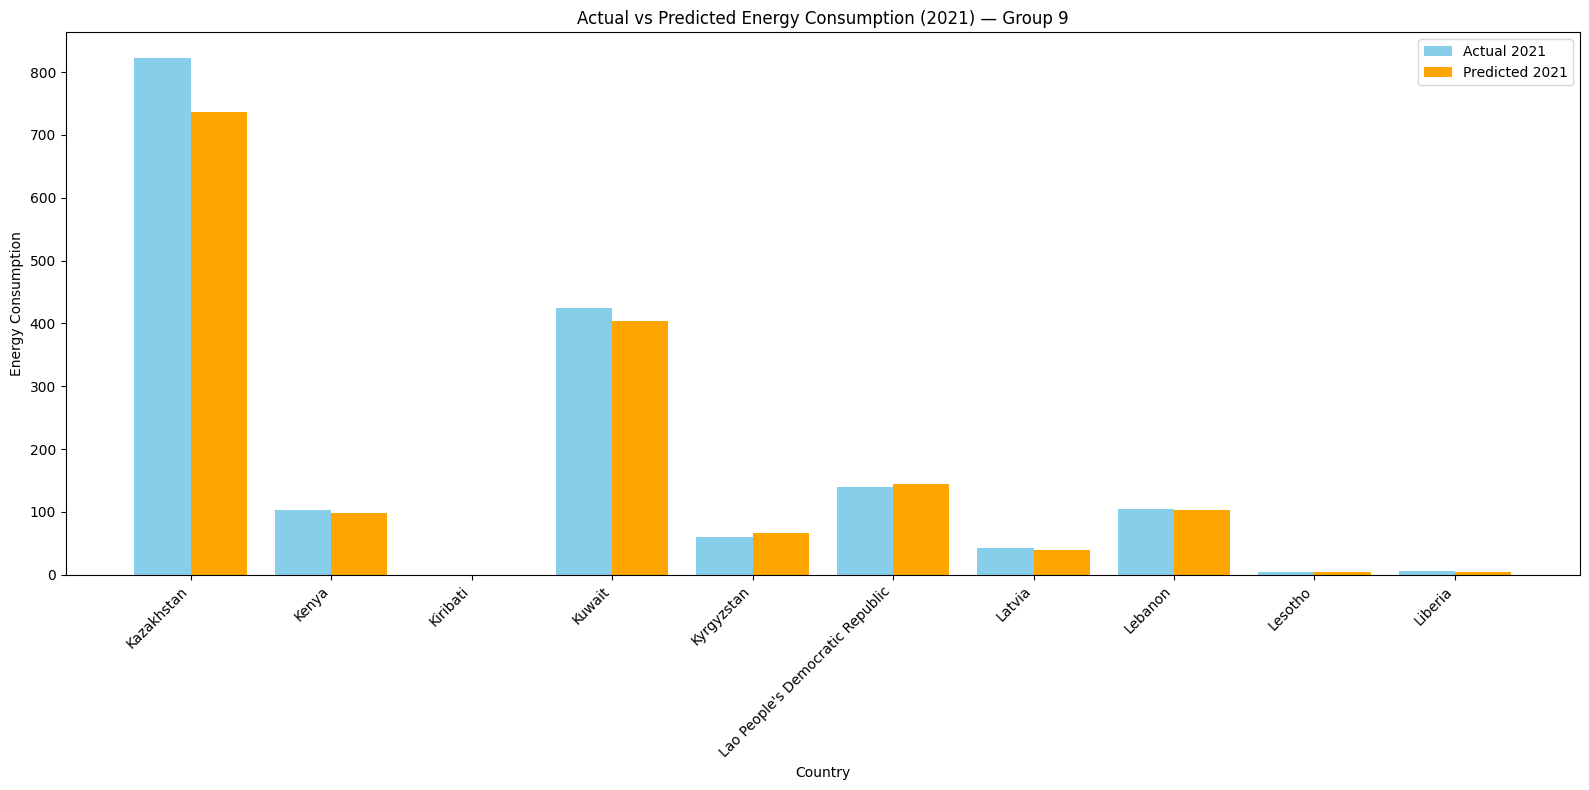

Plot saved to: /content/energy_comparison_2021_group_9.png


<Figure size 640x480 with 0 Axes>

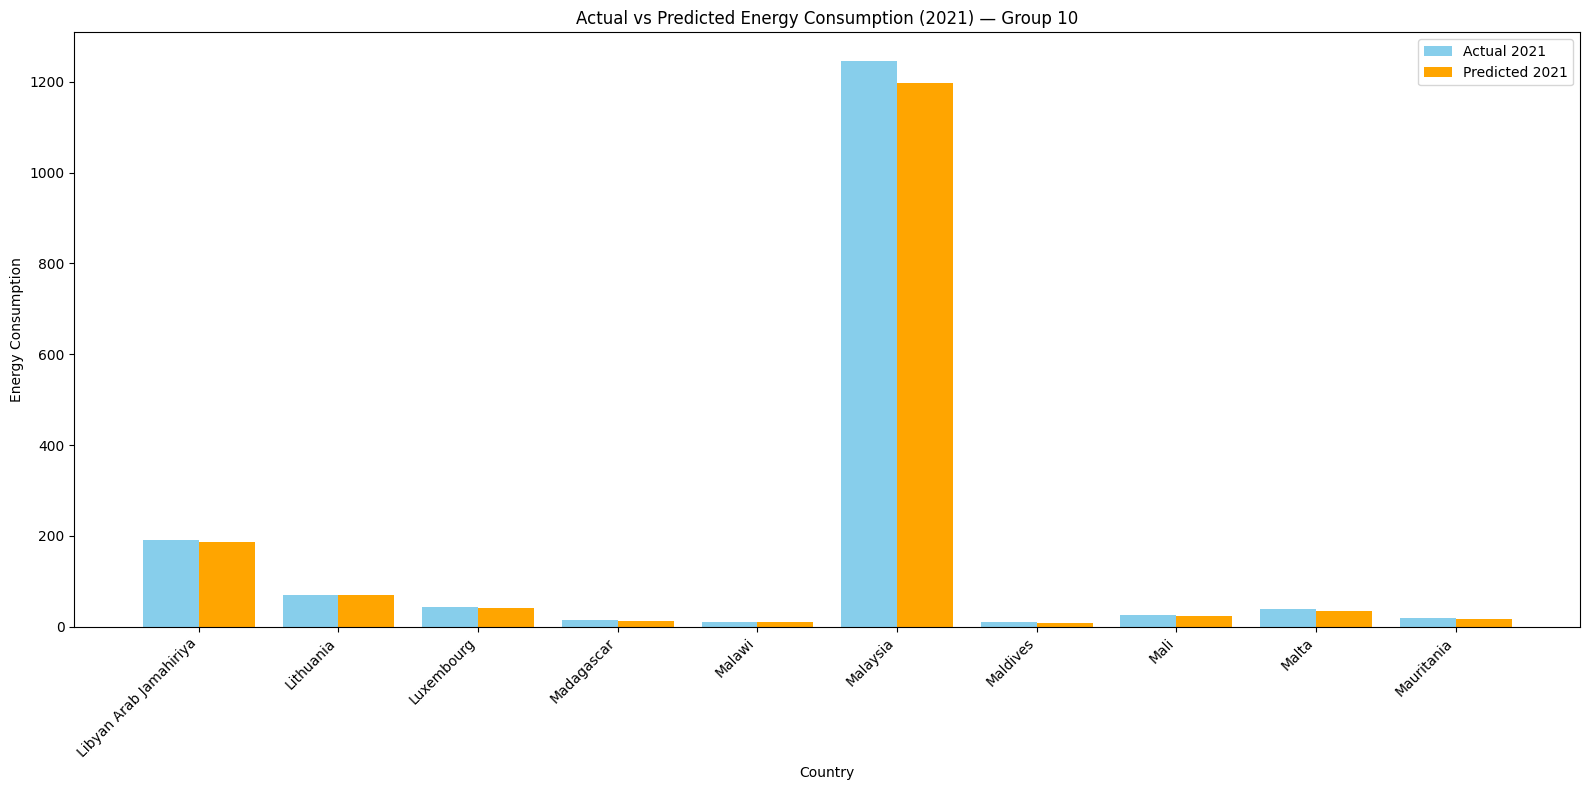

Plot saved to: /content/energy_comparison_2021_group_10.png


<Figure size 640x480 with 0 Axes>

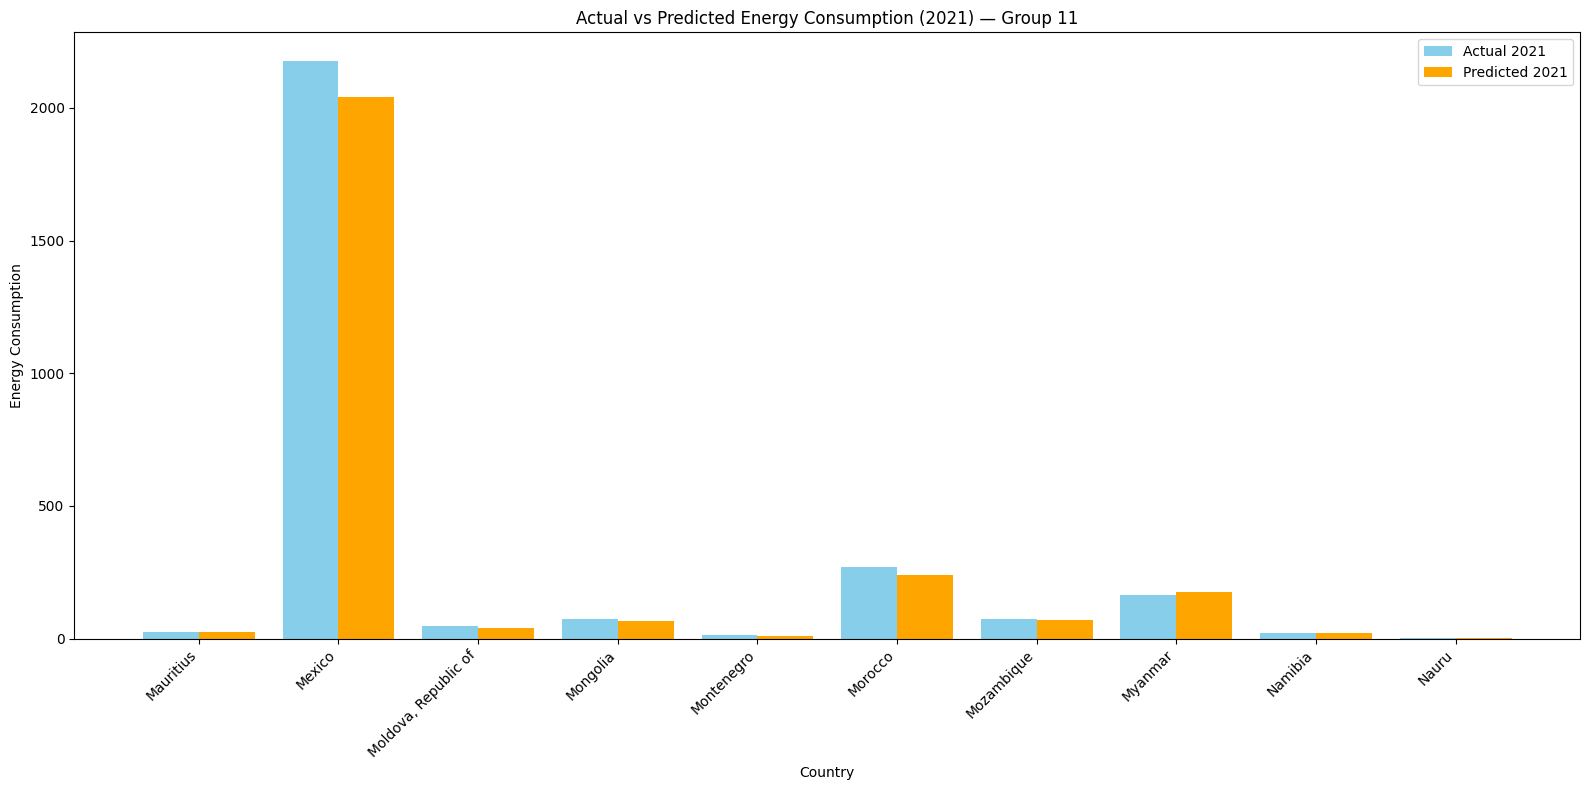

Plot saved to: /content/energy_comparison_2021_group_11.png


<Figure size 640x480 with 0 Axes>

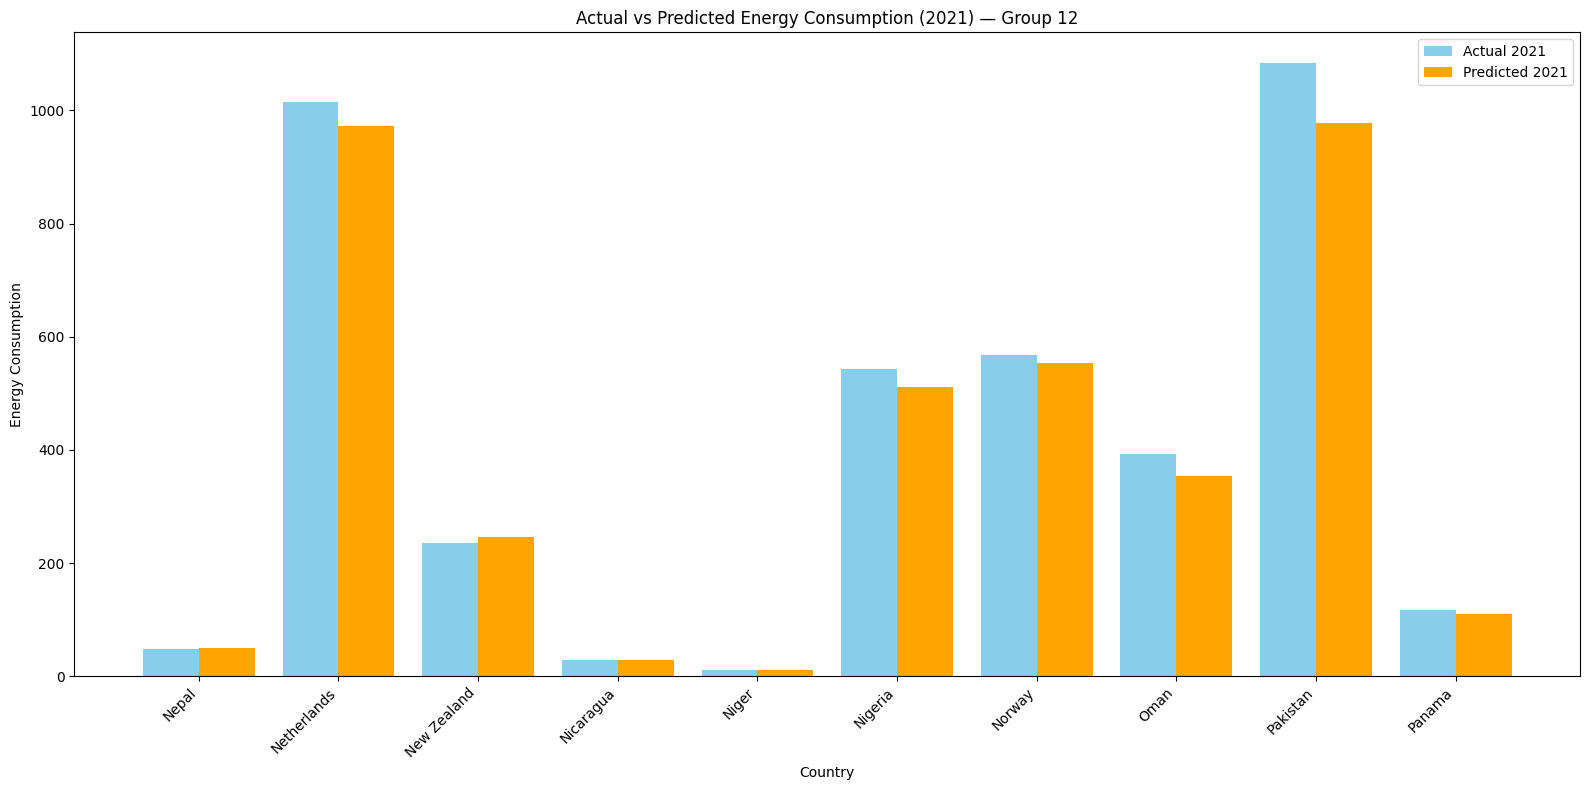

Plot saved to: /content/energy_comparison_2021_group_12.png


<Figure size 640x480 with 0 Axes>

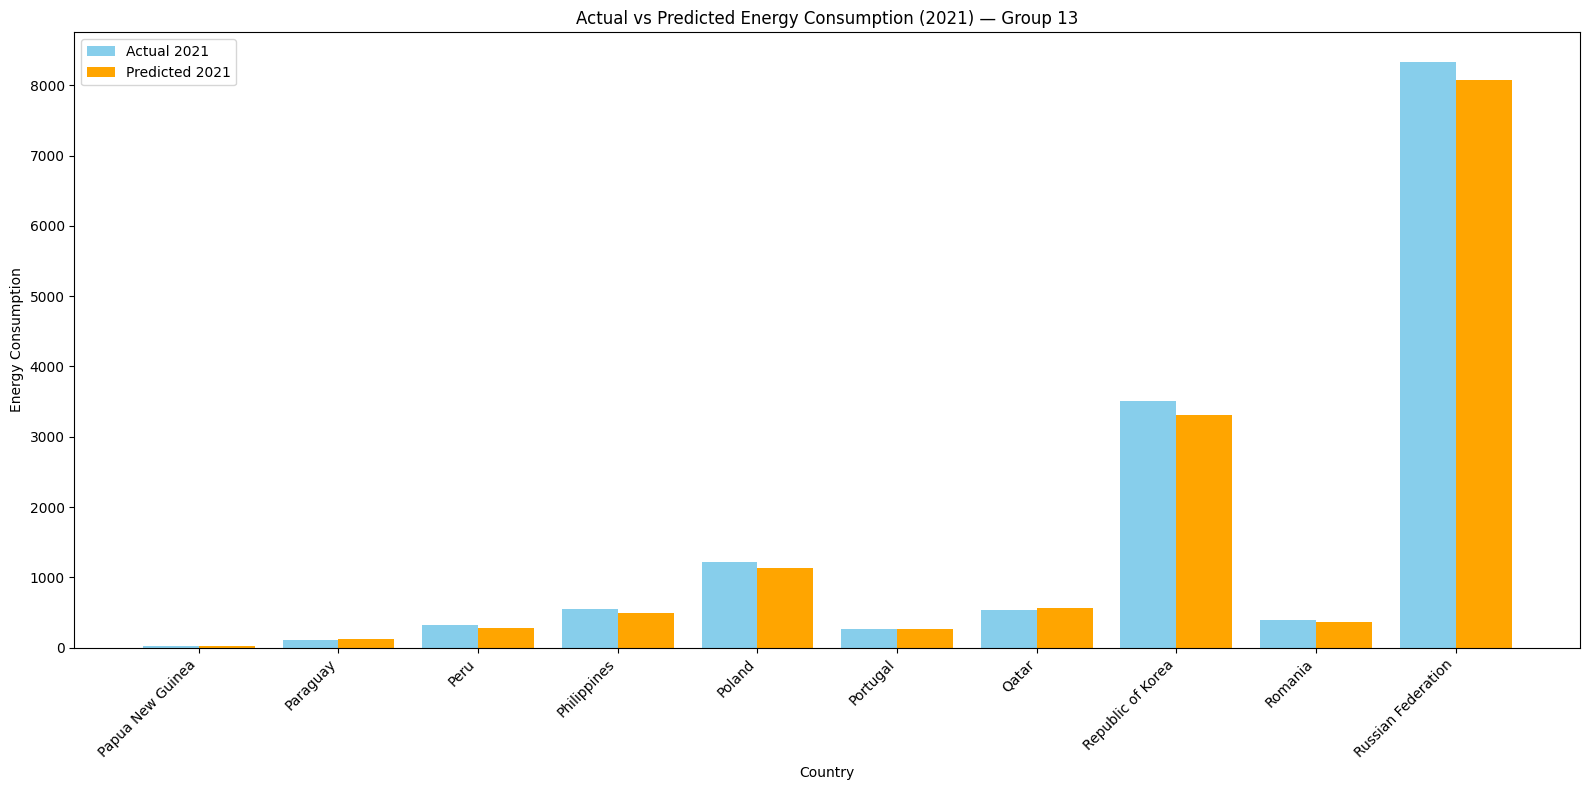

Plot saved to: /content/energy_comparison_2021_group_13.png


<Figure size 640x480 with 0 Axes>

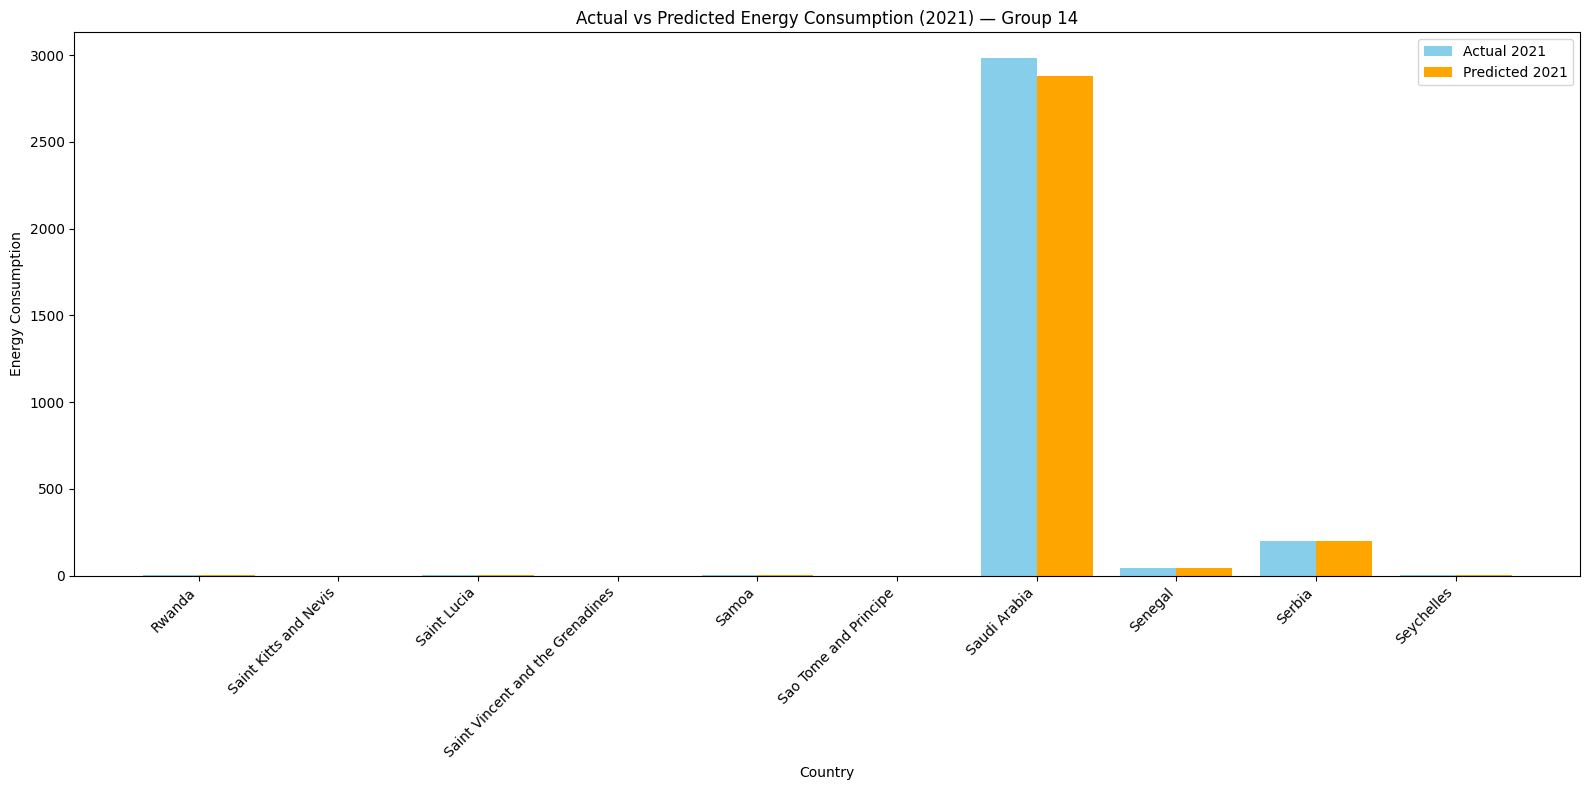

Plot saved to: /content/energy_comparison_2021_group_14.png


<Figure size 640x480 with 0 Axes>

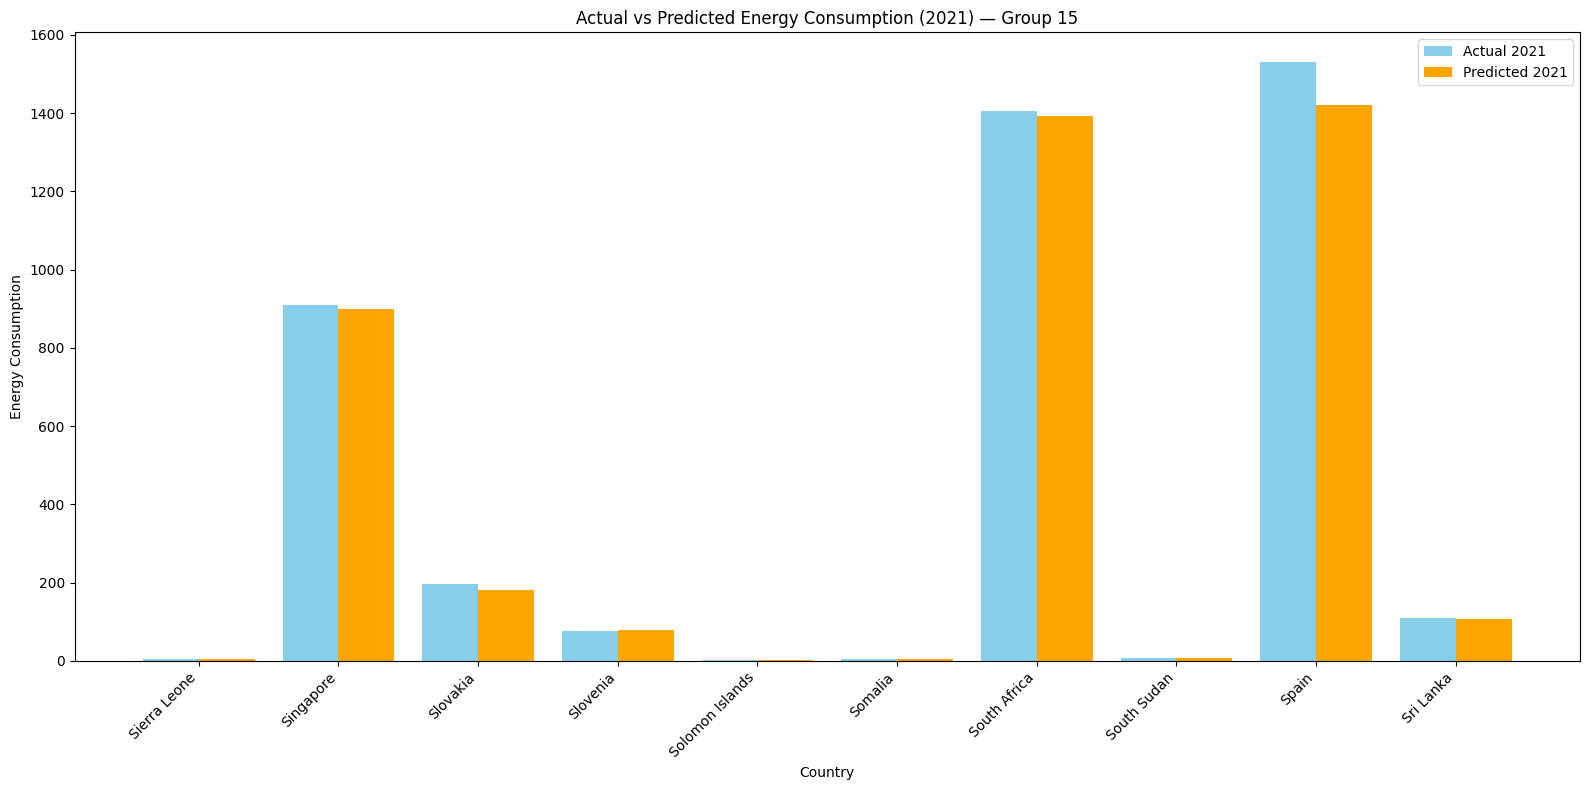

Plot saved to: /content/energy_comparison_2021_group_15.png


<Figure size 640x480 with 0 Axes>

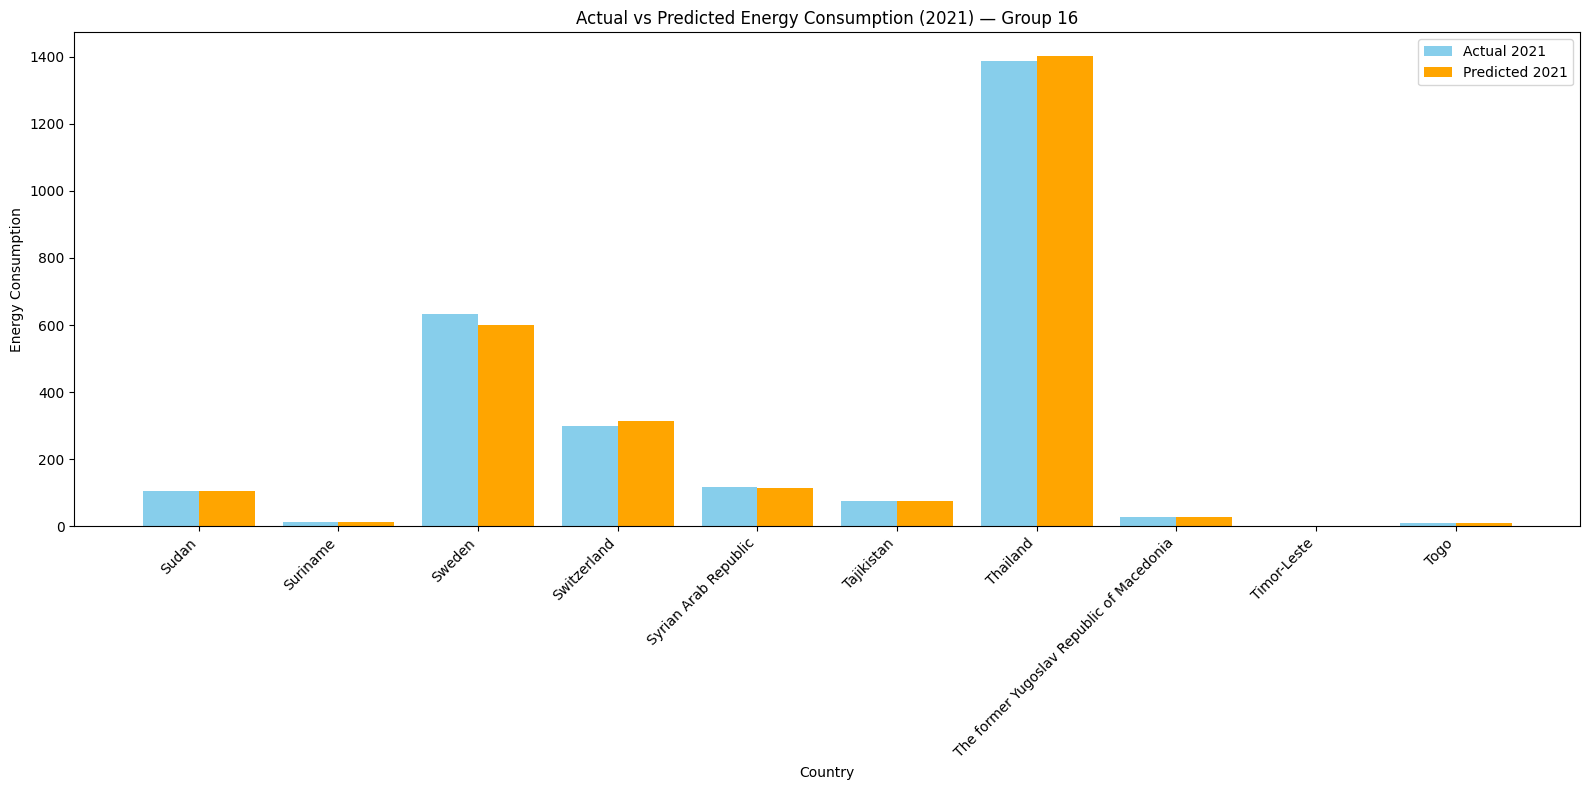

Plot saved to: /content/energy_comparison_2021_group_16.png


<Figure size 640x480 with 0 Axes>

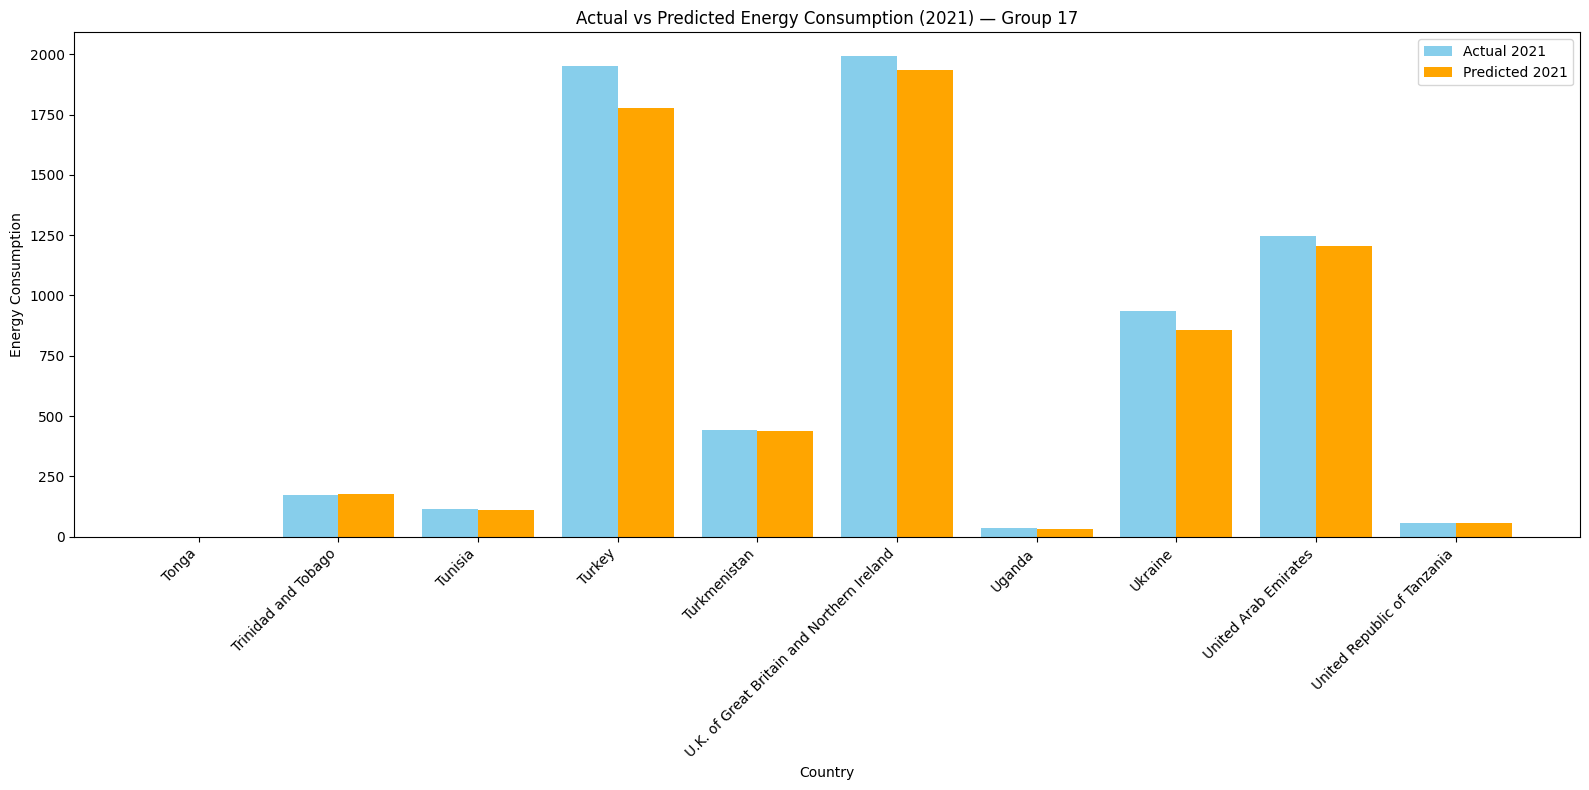

Plot saved to: /content/energy_comparison_2021_group_17.png


<Figure size 640x480 with 0 Axes>

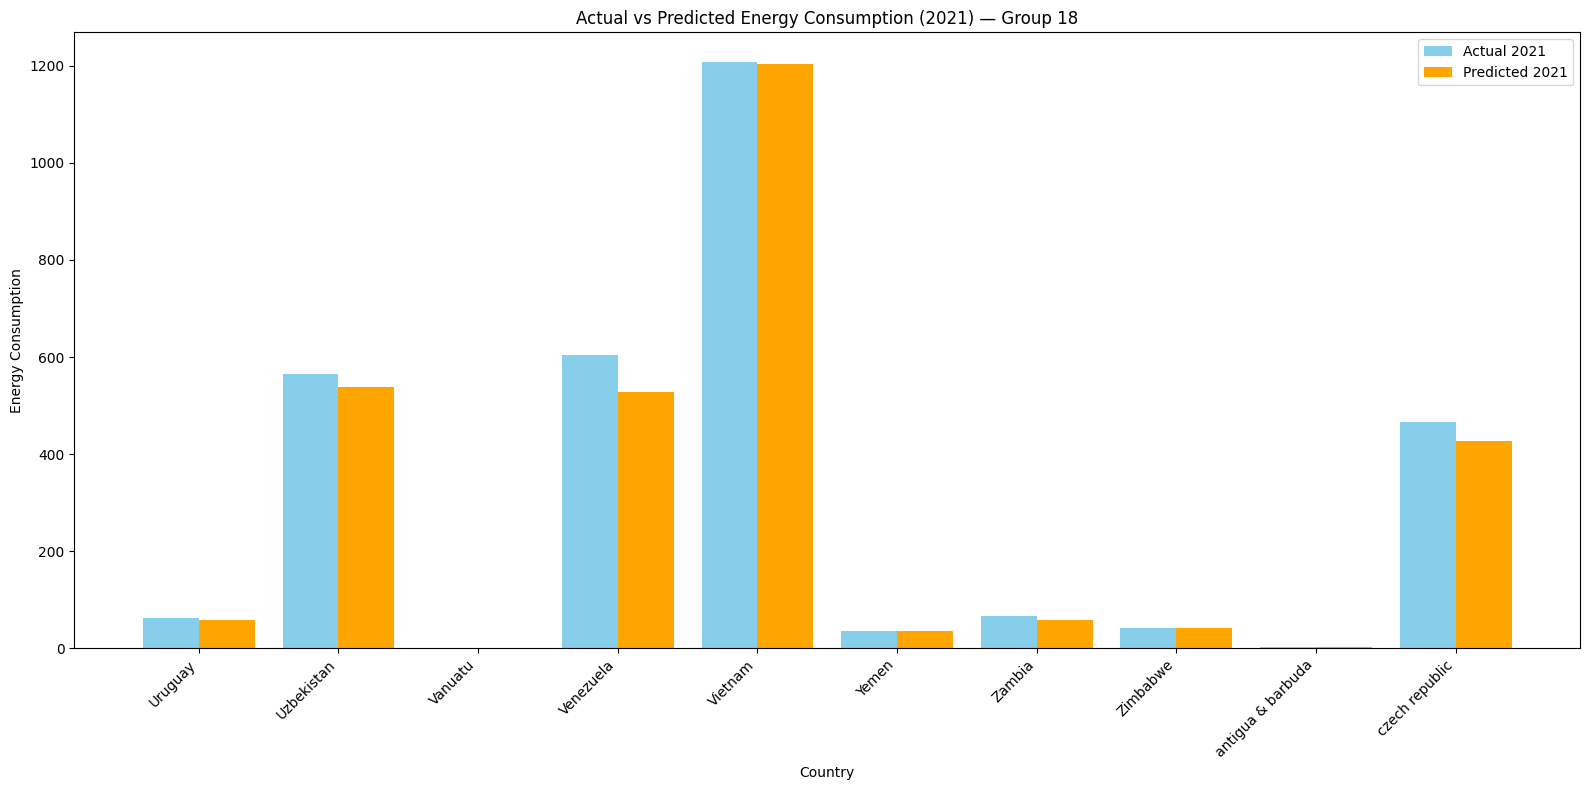

Plot saved to: /content/energy_comparison_2021_group_18.png


<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load actual 2021 energy consumption data
actual_df = pd.read_excel('/content/2021_Energy_data.xlsx')  # Must include: 'Country', '2021_energy_consumption'

# Load predicted 2021 energy consumption data
forecast_df = pd.read_excel('/content/forecast_energy_2021.xlsx')  # Must include: 'Country', 'Forecast_2021'

# Merge the two datasets on 'Country'
comparison_df = pd.merge(actual_df, forecast_df, on='Country')

# Rename columns for clarity
comparison_df.rename(columns={'2021_energy_consumption': 'Actual_2021', 'Forecast_2021': 'Predicted_2021'}, inplace=True)

# Split countries into chunks of 10 for separate plots
countries_per_plot = 10
chunks = [comparison_df.iloc[i:i + countries_per_plot] for i in range(0, len(comparison_df), countries_per_plot)]

# Plot each chunk
for idx, chunk in enumerate(chunks):
    plt.figure(figsize=(16, 8))

    # Bar width and positions
    bar_width = 0.4
    x = range(len(chunk))

    # Plot actual and predicted values side-by-side
    plt.bar(x, chunk['Actual_2021'], width=bar_width, label='Actual 2021', align='center', color='skyblue')
    plt.bar([i + bar_width for i in x], chunk['Predicted_2021'], width=bar_width, label='Predicted 2021', align='center', color='orange')

    # X-axis setup
    plt.xticks([i + bar_width / 2 for i in x], chunk['Country'], rotation=45, ha='right')

    # Labels and title
    plt.xlabel('Country')
    plt.ylabel('Energy Consumption')
    plt.title(f'Actual vs Predicted Energy Consumption (2021) — Group {idx + 1}')
    plt.legend()

    # Layout and show
    plt.tight_layout()
    plt.show()

    # Optionally save each plot
    plot_path = f'/content/energy_comparison_2021_group_{idx + 1}.png'
    plt.savefig(plot_path)
    print(f"Plot saved to: {plot_path}")


**Random Forest without log transformation**

Random Forest - R² Score: 0.8738
Random Forest - RMSE: 1222.91


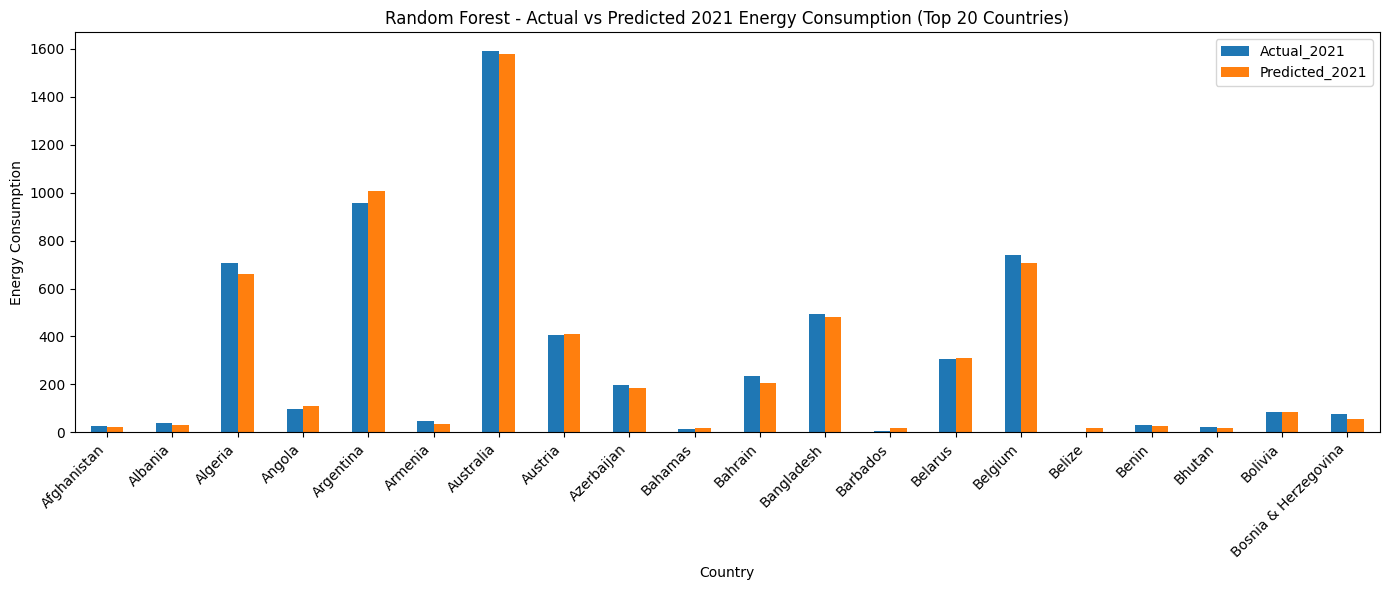

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load feature dataset (2013-2020 data)
features_df = pd.read_excel('/content/structured_combined_data_train.xlsx')

# Load actual 2021 target values
target_df = pd.read_excel('/content/2021_Energy_data.xlsx')  # contains 'Country' and '2021_energy_consumption'

# Merge both datasets on 'Country'
merged_df = pd.merge(features_df, target_df, on='Country')

# Define feature columns (all columns except Country and 2021 target)
X = merged_df.drop(columns=['Country', '2021_energy_consumption'])
y = merged_df['2021_energy_consumption']

# Train Random Forest Regressor
model_rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model_rf.fit(X, y)

# Predict
y_pred_rf = model_rf.predict(X)

# Evaluate
r2_rf = r2_score(y, y_pred_rf)
rmse_rf = mean_squared_error(y, y_pred_rf) ** 0.5

print(f"Random Forest - R² Score: {r2_rf:.4f}")
print(f"Random Forest - RMSE: {rmse_rf:.2f}")

# Save predictions with countries
results_rf = pd.DataFrame({
    'Country': merged_df['Country'],
    'Actual_2021': y,
    'Predicted_2021': y_pred_rf
})

# Save to Excel
results_rf.to_excel('/content/random_forest_energy_2021_predictions.xlsx', index=False)

# Plot actual vs predicted for first 20 countries
results_rf.head(20).plot(x='Country', kind='bar', figsize=(14,6))
plt.title('Random Forest - Actual vs Predicted 2021 Energy Consumption (Top 20 Countries)')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**xgboost LOG**

R² Score: 0.9988
RMSE: 120.38


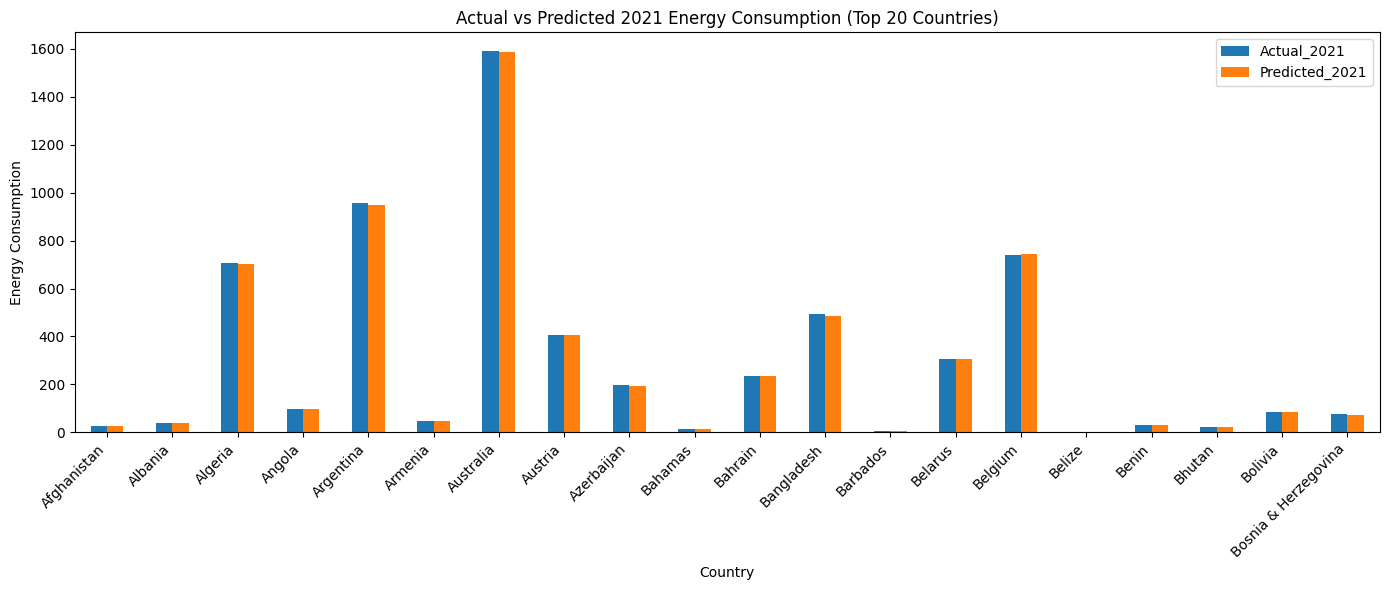

In [5]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load feature dataset (2013-2020 data)
features_df = pd.read_excel('/content/structured_combined_data_train.xlsx')

# Load actual 2021 target values
target_df = pd.read_excel('/content/2021_Energy_data.xlsx')  # contains 'Country' and '2021_energy_consumption'

# Merge both datasets on 'Country'
merged_df = pd.merge(features_df, target_df, on='Country')

# Define feature columns (all columns except Country and 2021 target)
X = merged_df.drop(columns=['Country', '2021_energy_consumption'])
y_raw = merged_df['2021_energy_consumption']

# Apply log transformation
y_log = np.log1p(y_raw)

# Train XGBoost Regressor on log-transformed data
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X, y_log)

# Predict and revert log transformation
y_log_pred = model.predict(X)
y_pred = np.expm1(y_log_pred)

# Evaluate on original scale
r2 = r2_score(y_raw, y_pred)
rmse = mean_squared_error(y_raw, y_pred) ** 0.5


print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# Save predictions with countries
results = pd.DataFrame({
    'Country': merged_df['Country'],
    'Actual_2021': y_raw,
    'Predicted_2021': y_pred
})

# Save to Excel
results.to_excel('/content/xgboost_energy_2021_predictions_log.xlsx', index=False)

# Plot actual vs predicted for first 20 countries
results.head(20).plot(x='Country', kind='bar', figsize=(14,6))
plt.title('Actual vs Predicted 2021 Energy Consumption (Top 20 Countries)')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




**Ridge Regression (No Log)**


🔎 Ridge Regression (No Log) Results
R² Score: 1.0000
RMSE: 12.11


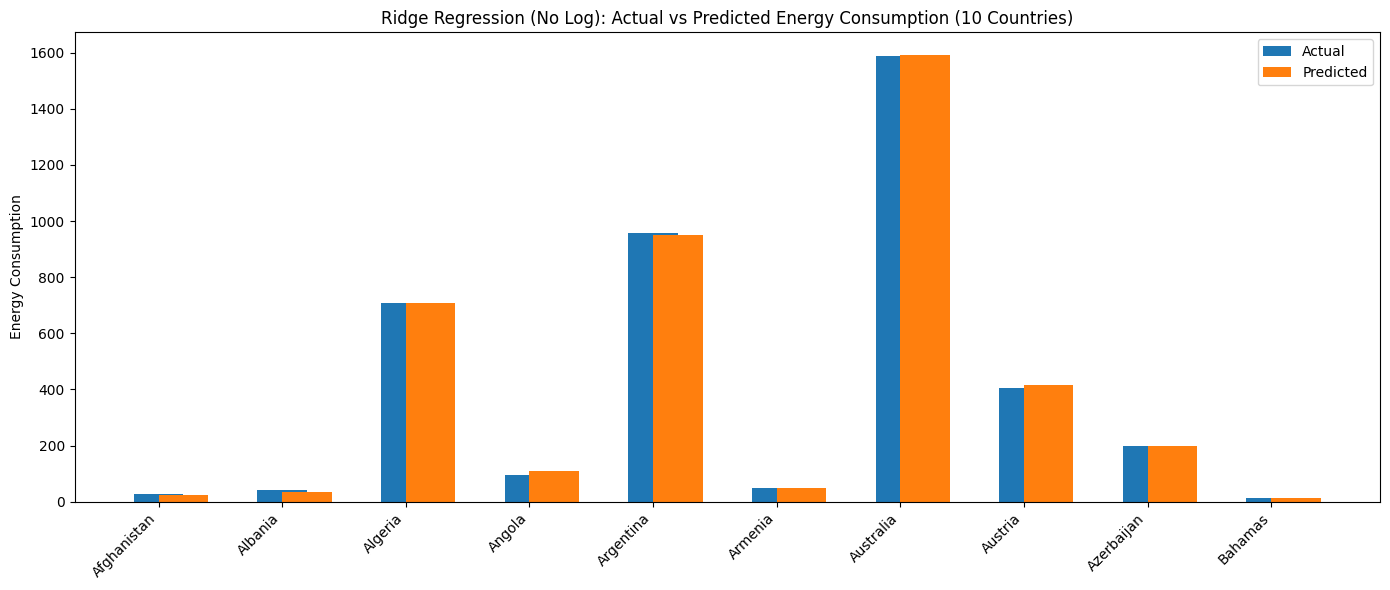

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load and merge datasets
features_df = pd.read_excel('/content/structured_combined_data_train.xlsx')
target_df = pd.read_excel('/content/2021_Energy_data.xlsx')
merged_df = pd.merge(features_df, target_df, on='Country')

# Prepare data
X = merged_df.drop(columns=['Country', '2021_energy_consumption'])
y = merged_df['2021_energy_consumption']  # No log transformation

# Train Ridge model
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)
y_pred = ridge.predict(X)

# Evaluation
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("\n🔎 Ridge Regression (No Log) Results")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# Plot for any 10 countries
results = pd.DataFrame({
    'Country': merged_df['Country'],
    'Actual_2021': y,
    'Predicted_2021': y_pred
})
sample_10 = results.head(10)

plt.figure(figsize=(14, 6))
plt.bar(sample_10['Country'], sample_10['Actual_2021'], width=0.4, label='Actual', align='center')
plt.bar(sample_10['Country'], sample_10['Predicted_2021'], width=0.4, label='Predicted', align='edge')
plt.xticks(rotation=45, ha='right')
plt.title('Ridge Regression (No Log): Actual vs Predicted Energy Consumption (10 Countries)')
plt.ylabel('Energy Consumption')
plt.legend()
plt.tight_layout()
plt.show()


**Lasso Regression (No Log)**

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.351e+05, tolerance: 2.133e+05
  model = cd_fast.enet_coordinate_descent(



🔎 Lasso Regression (No Log) Results
R² Score: 0.9998
RMSE: 51.11


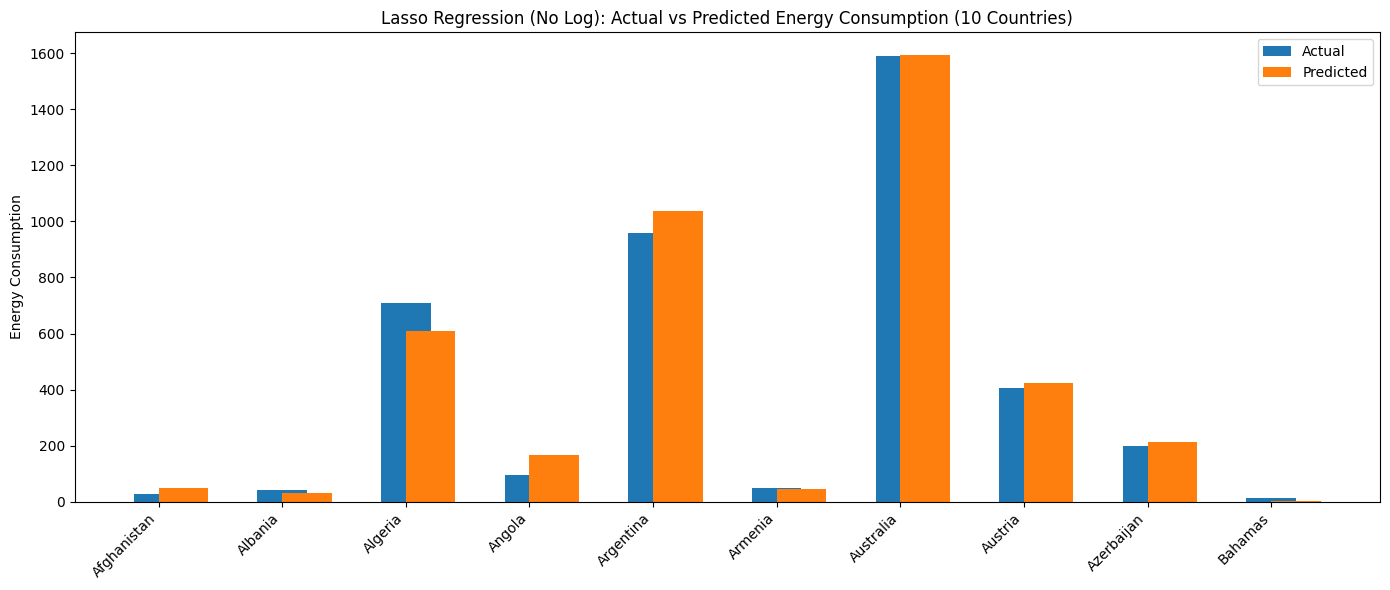

In [8]:
from sklearn.linear_model import Lasso
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load and merge datasets
features_df = pd.read_excel('/content/structured_combined_data_train.xlsx')
target_df = pd.read_excel('/content/2021_Energy_data.xlsx')
merged_df = pd.merge(features_df, target_df, on='Country')

# Prepare data
X = merged_df.drop(columns=['Country', '2021_energy_consumption'])
y = merged_df['2021_energy_consumption']  # No log transformation

# Train Lasso model
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)
y_pred = lasso.predict(X)  # No log involved

# Evaluation
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("\n🔎 Lasso Regression (No Log) Results")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# Plot for any 10 countries
results = pd.DataFrame({
    'Country': merged_df['Country'],
    'Actual_2021': y,
    'Predicted_2021': y_pred
})
sample_10 = results.head(10)

plt.figure(figsize=(14, 6))
plt.bar(sample_10['Country'], sample_10['Actual_2021'], width=0.4, label='Actual', align='center')
plt.bar(sample_10['Country'], sample_10['Predicted_2021'], width=0.4, label='Predicted', align='edge')
plt.xticks(rotation=45, ha='right')
plt.title('Lasso Regression (No Log): Actual vs Predicted Energy Consumption (10 Countries)')
plt.ylabel('Energy Consumption')
plt.legend()
plt.tight_layout()
plt.show()


**Linear regression no log**

Linear Regression (No Log) R² Score: 1.0000
Linear Regression (No Log) RMSE: 12.11


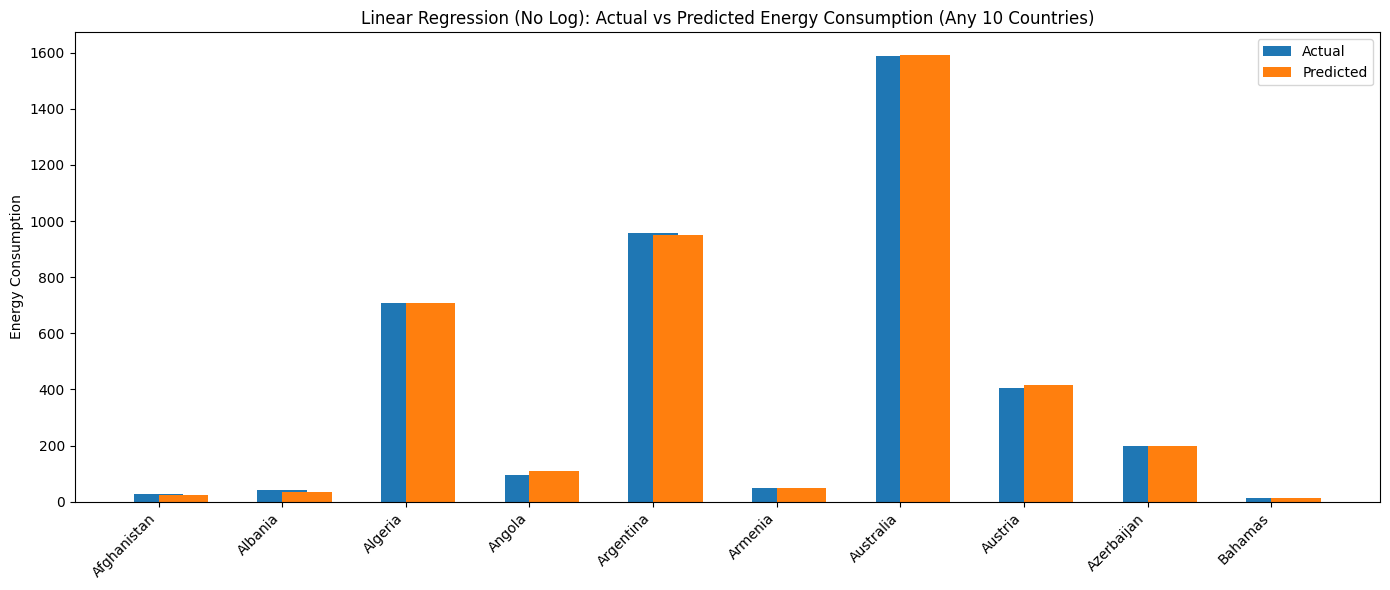

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load datasets
features_df = pd.read_excel('/content/structured_combined_data_train.xlsx')
target_df = pd.read_excel('/content/2021_Energy_data.xlsx')

# Merge on 'Country'
merged_df = pd.merge(features_df, target_df, on='Country')

# Prepare features and target (no log)
X = merged_df.drop(columns=['Country', '2021_energy_consumption'])
y_raw = merged_df['2021_energy_consumption']

# Train model
model = LinearRegression()
model.fit(X, y_raw)

# Predict
y_pred = model.predict(X)

# Evaluation
r2 = r2_score(y_raw, y_pred)
rmse = np.sqrt(mean_squared_error(y_raw, y_pred))

print(f"Linear Regression (No Log) R² Score: {r2:.4f}")
print(f"Linear Regression (No Log) RMSE: {rmse:.2f}")

# Save predictions
results = pd.DataFrame({
    'Country': merged_df['Country'],
    'Actual_2021': y_raw,
    'Predicted_2021': y_pred
})

results.to_excel('/content/linear_regression_energy_2021_predictions_no_log.xlsx', index=False)

# Plot any 10 countries
sample_countries = results.head(10)

plt.figure(figsize=(14, 6))
plt.bar(sample_countries['Country'], sample_countries['Actual_2021'], width=0.4, label='Actual', align='center')
plt.bar(sample_countries['Country'], sample_countries['Predicted_2021'], width=0.4, label='Predicted', align='edge')
plt.title('Linear Regression (No Log): Actual vs Predicted Energy Consumption (Any 10 Countries)')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()



🔎 SVR Model Evaluation (No Log)
R² Score: 0.0691
RMSE: 3321.10


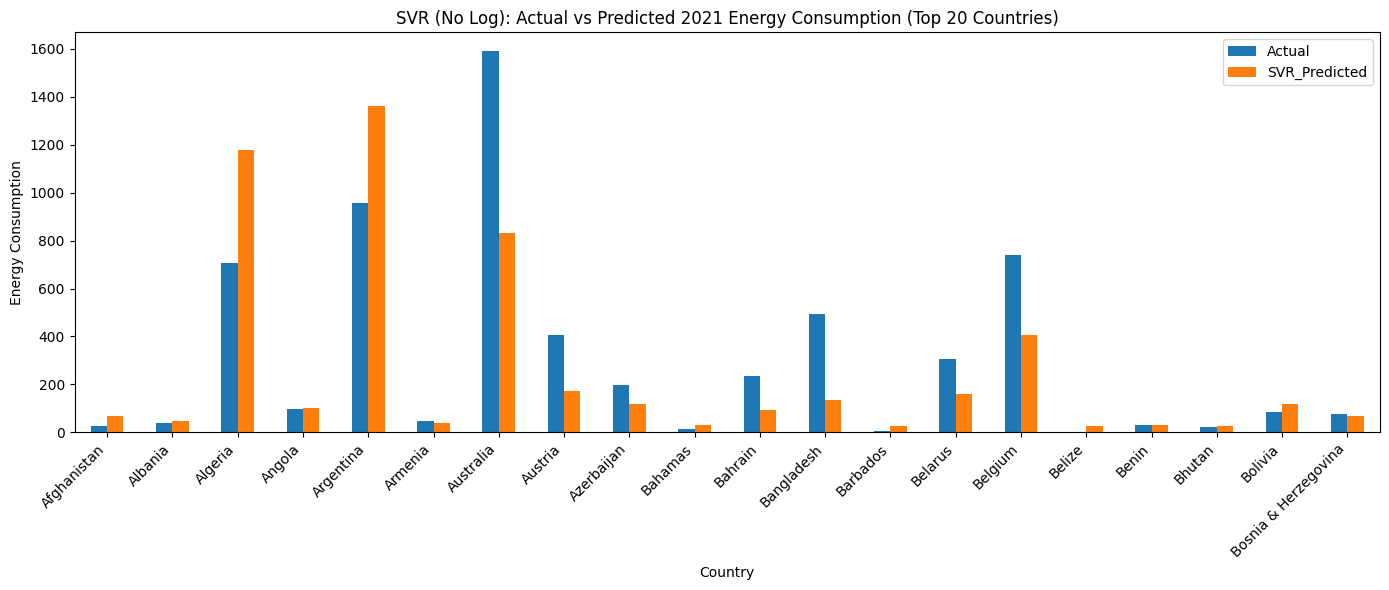

In [12]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load data
features_df = pd.read_excel('/content/structured_combined_data_train.xlsx')
target_df = pd.read_excel('/content/2021_Energy_data.xlsx')

# Merge datasets
merged_df = pd.merge(features_df, target_df, on='Country')

# Features and target
X = merged_df.drop(columns=['Country', '2021_energy_consumption'])
y = merged_df['2021_energy_consumption']

# Scale features (important for SVR)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train SVR on raw (unlogged) energy consumption
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)
svr_model.fit(X_scaled, y)

# Predict directly
y_pred = svr_model.predict(X_scaled)

# Evaluate
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"\n🔎 SVR Model Evaluation (No Log)")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# Plot predictions
results = pd.DataFrame({
    'Country': merged_df['Country'],
    'Actual': y,
    'SVR_Predicted': y_pred
})

# Save to Excel
results.to_excel('/content/svr_energy_2021_predictions_no_log.xlsx', index=False)

# Plot top 20 countries
results.head(20).plot(x='Country', kind='bar', figsize=(14,6))
plt.title('SVR (No Log): Actual vs Predicted 2021 Energy Consumption (Top 20 Countries)')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




Linear regression with log

Linear Regression R² Score: 0.6974
Linear Regression RMSE: 1893.65


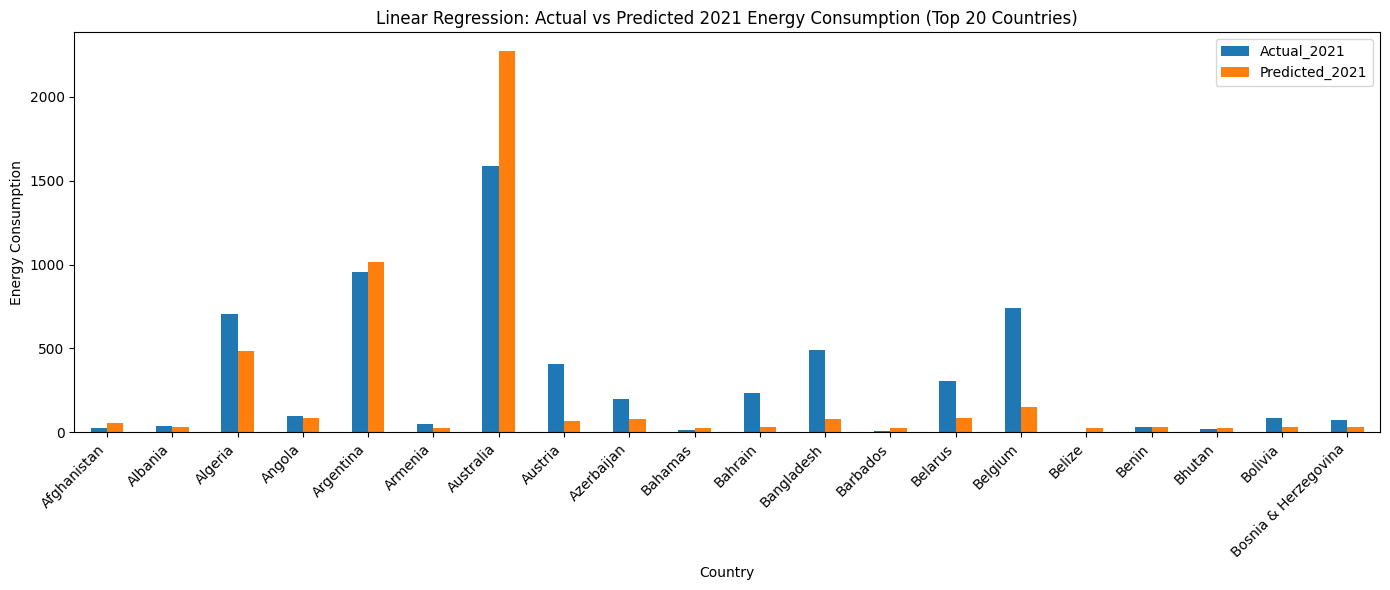

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load feature and target datasets
features_df = pd.read_excel('/content/structured_combined_data_train.xlsx')
target_df = pd.read_excel('/content/2021_Energy_data.xlsx')  # contains 'Country' and '2021_energy_consumption'

# Merge on 'Country'
merged_df = pd.merge(features_df, target_df, on='Country')

# Prepare features and log-transformed target
X = merged_df.drop(columns=['Country', '2021_energy_consumption'])
y_raw = merged_df['2021_energy_consumption']
y = np.log1p(y_raw)  # log(1 + y) to avoid log(0)

# Train Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict and inverse log
y_pred_log = model.predict(X)
y_pred = np.expm1(y_pred_log)  # inverse of log1p

# Evaluate on original scale
r2 = r2_score(y_raw, y_pred)
rmse = mean_squared_error(y_raw, y_pred) ** 0.5

print(f"Linear Regression R² Score: {r2:.4f}")
print(f"Linear Regression RMSE: {rmse:.2f}")

# Save predictions
results = pd.DataFrame({
    'Country': merged_df['Country'],
    'Actual_2021': y_raw,
    'Predicted_2021': y_pred
})

results.to_excel('/content/linear_regression_energy_2021_predictions.xlsx', index=False)

# Plot top 20
results.head(20).plot(x='Country', kind='bar', figsize=(14, 6))
plt.title('Linear Regression: Actual vs Predicted 2021 Energy Consumption (Top 20 Countries)')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




**random forest with log**

Random Forest R² Score: 0.7586
Random Forest RMSE: 1691.24


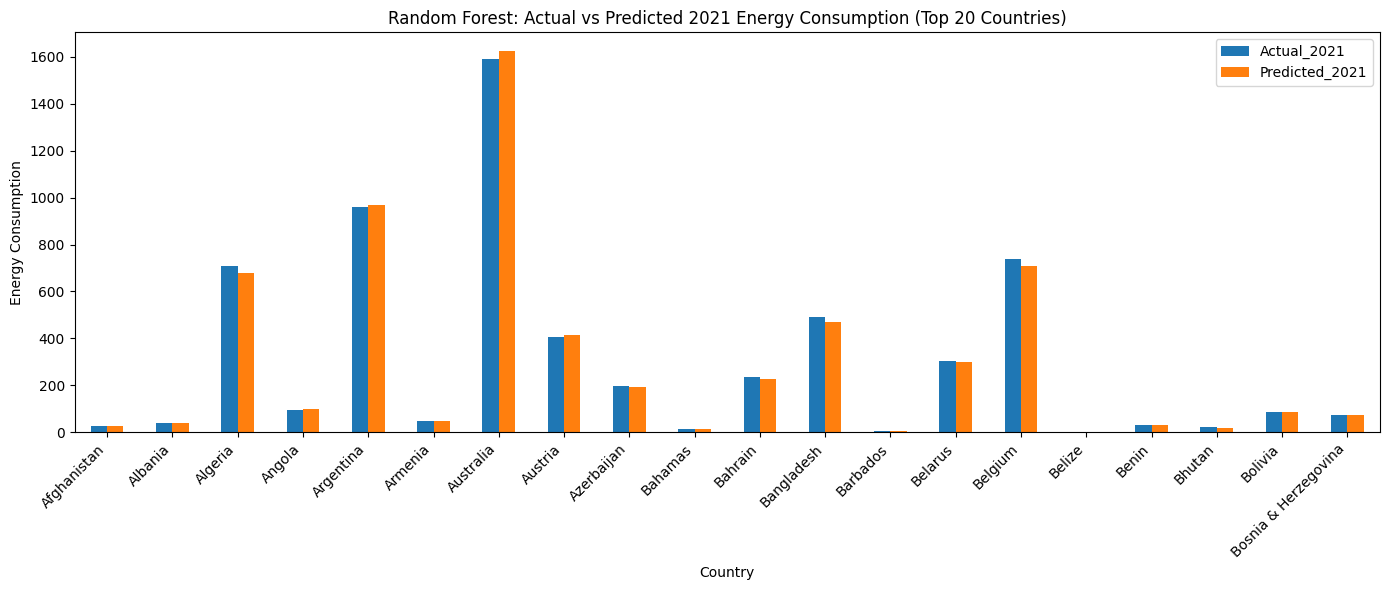

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load the datasets
features_df = pd.read_excel('/content/structured_combined_data_train.xlsx')
target_df = pd.read_excel('/content/2021_Energy_data.xlsx')  # contains 'Country' and '2021_energy_consumption'

# Merge on 'Country'
merged_df = pd.merge(features_df, target_df, on='Country')

# Prepare features and log-transformed target
X = merged_df.drop(columns=['Country', '2021_energy_consumption'])
y_raw = merged_df['2021_energy_consumption']
y = np.log1p(y_raw)

# Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
model.fit(X, y)

# Predict and inverse log
y_pred_log = model.predict(X)
y_pred = np.expm1(y_pred_log)

# Evaluate on original scale
r2 = r2_score(y_raw, y_pred)
rmse = mean_squared_error(y_raw, y_pred) ** 0.5

print(f"Random Forest R² Score: {r2:.4f}")
print(f"Random Forest RMSE: {rmse:.2f}")

# Save predictions
results = pd.DataFrame({
    'Country': merged_df['Country'],
    'Actual_2021': y_raw,
    'Predicted_2021': y_pred
})

results.to_excel('/content/random_forest_energy_2021_predictions.xlsx', index=False)

# Plot top 20
results.head(20).plot(x='Country', kind='bar', figsize=(14, 6))
plt.title('Random Forest: Actual vs Predicted 2021 Energy Consumption (Top 20 Countries)')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**SVR with log**


🔎 SVR Model Evaluation
R² Score: 0.9873
RMSE: 387.29


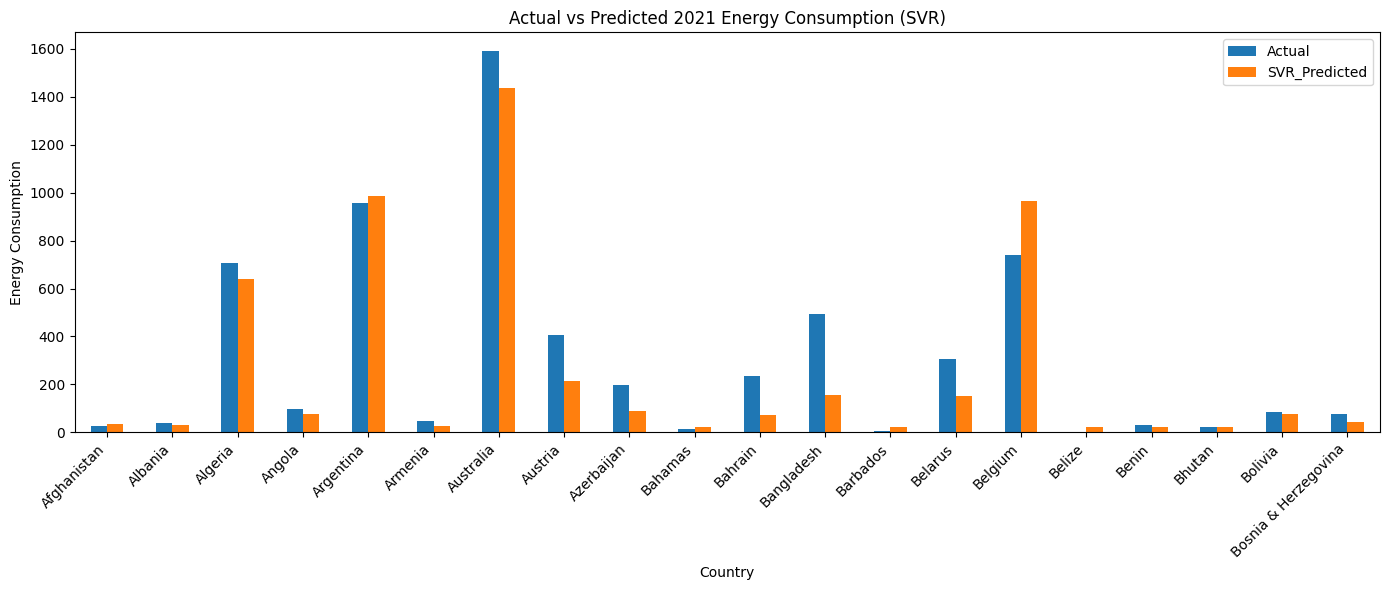

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load data
features_df = pd.read_excel('/content/structured_combined_data_train.xlsx')
target_df = pd.read_excel('/content/2021_Energy_data.xlsx')

# Merge datasets
merged_df = pd.merge(features_df, target_df, on='Country')

# Features and target
X = merged_df.drop(columns=['Country', '2021_energy_consumption'])
y_raw = merged_df['2021_energy_consumption']
y = np.log1p(y_raw)  # log transform the target

# Scale features (important for SVR)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train SVR
svr_model = SVR(kernel='rbf', C=100, epsilon=0.1)
svr_model.fit(X_scaled, y)

# Predict and inverse log
y_pred_log = svr_model.predict(X_scaled)
y_pred = np.expm1(y_pred_log)

# Evaluate
r2 = r2_score(y_raw, y_pred)
rmse = np.sqrt(mean_squared_error(y_raw, y_pred))
print(f"\n🔎 SVR Model Evaluation")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# Plot predictions
results = pd.DataFrame({
    'Country': merged_df['Country'],
    'Actual': y_raw,
    'SVR_Predicted': y_pred
})

results.head(20).plot(x='Country', kind='bar', figsize=(14,6))
plt.title('Actual vs Predicted 2021 Energy Consumption (SVR)')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Ridge regression with log**


🔎 Ridge Regression Results
R² Score: 0.6974
RMSE: 1893.64


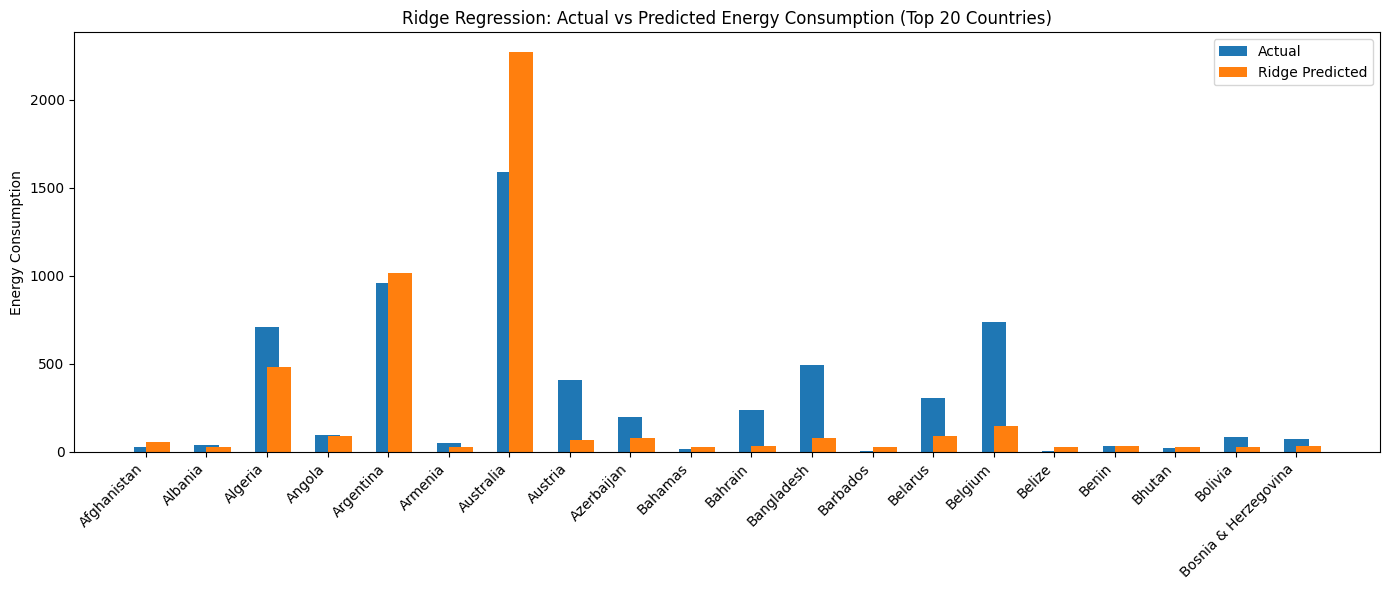

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load and merge datasets
features_df = pd.read_excel('/content/structured_combined_data_train.xlsx')
target_df = pd.read_excel('/content/2021_Energy_data.xlsx')
merged_df = pd.merge(features_df, target_df, on='Country')

# Prepare data
X = merged_df.drop(columns=['Country', '2021_energy_consumption'])
y_raw = merged_df['2021_energy_consumption']
y = np.log1p(y_raw)

# Train Ridge model
ridge = Ridge(alpha=1.0)
ridge.fit(X, y)
y_pred_log = ridge.predict(X)
y_pred = np.expm1(y_pred_log)

# Evaluation
r2 = r2_score(y_raw, y_pred)
rmse = np.sqrt(mean_squared_error(y_raw, y_pred))
print("\n🔎 Ridge Regression Results")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(14,6))
plt.bar(merged_df['Country'][:20], y_raw[:20], width=0.4, label='Actual', align='center')
plt.bar(merged_df['Country'][:20], y_pred[:20], width=0.4, label='Ridge Predicted', align='edge')
plt.xticks(rotation=45, ha='right')
plt.title('Ridge Regression: Actual vs Predicted Energy Consumption (Top 20 Countries)')
plt.ylabel('Energy Consumption')
plt.legend()
plt.tight_layout()
plt.show()


**Lasso with log**

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e+02, tolerance: 8.568e-02
  model = cd_fast.enet_coordinate_descent(



🔎 Lasso Regression Results
R² Score: -0.1226
RMSE: 3647.06


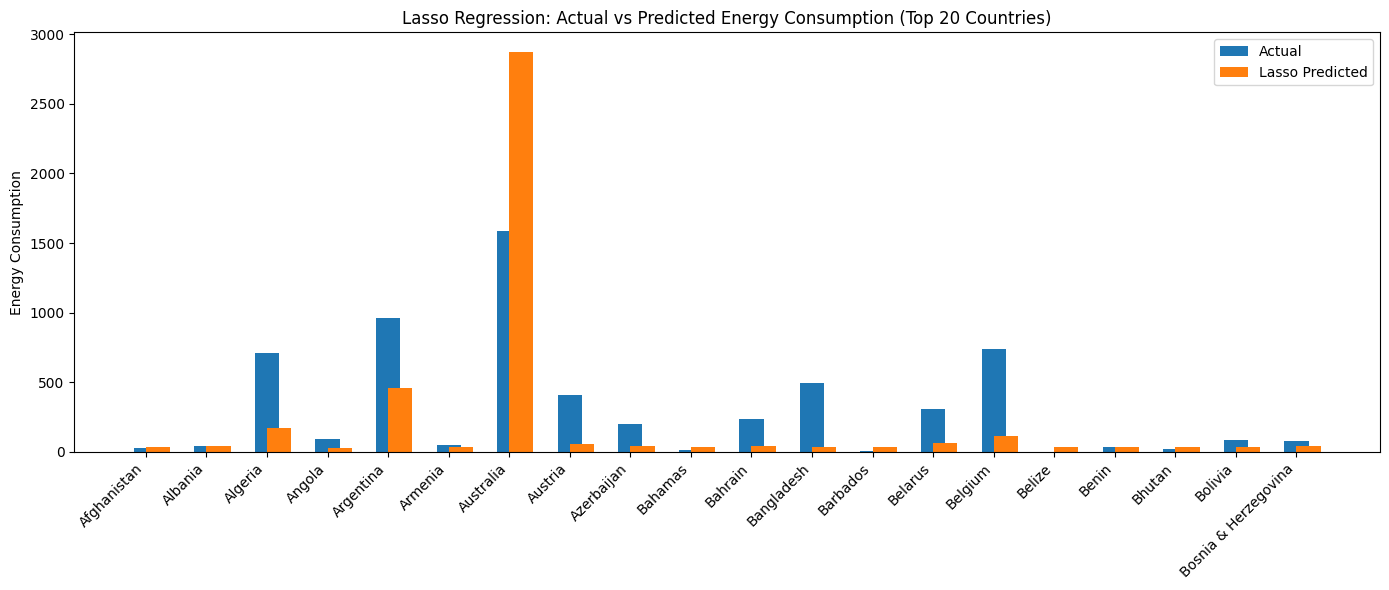

In [ ]:
from sklearn.linear_model import Lasso

# Train Lasso model
lasso = Lasso(alpha=0.01)
lasso.fit(X, y)
y_pred_log = lasso.predict(X)
y_pred = np.expm1(y_pred_log)

# Evaluation
r2 = r2_score(y_raw, y_pred)
rmse = np.sqrt(mean_squared_error(y_raw, y_pred))
print("\n🔎 Lasso Regression Results")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(14,6))
plt.bar(merged_df['Country'][:20], y_raw[:20], width=0.4, label='Actual', align='center')
plt.bar(merged_df['Country'][:20], y_pred[:20], width=0.4, label='Lasso Predicted', align='edge')
plt.xticks(rotation=45, ha='right')
plt.title('Lasso Regression: Actual vs Predicted Energy Consumption (Top 20 Countries)')
plt.ylabel('Energy Consumption')
plt.legend()
plt.tight_layout()
plt.show()


**MLP REgessor with log**

**LSTM model**

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0191
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054     
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049     
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042     
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031     
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053      
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040      
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035     
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022     
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029      
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0010     
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013     
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step -

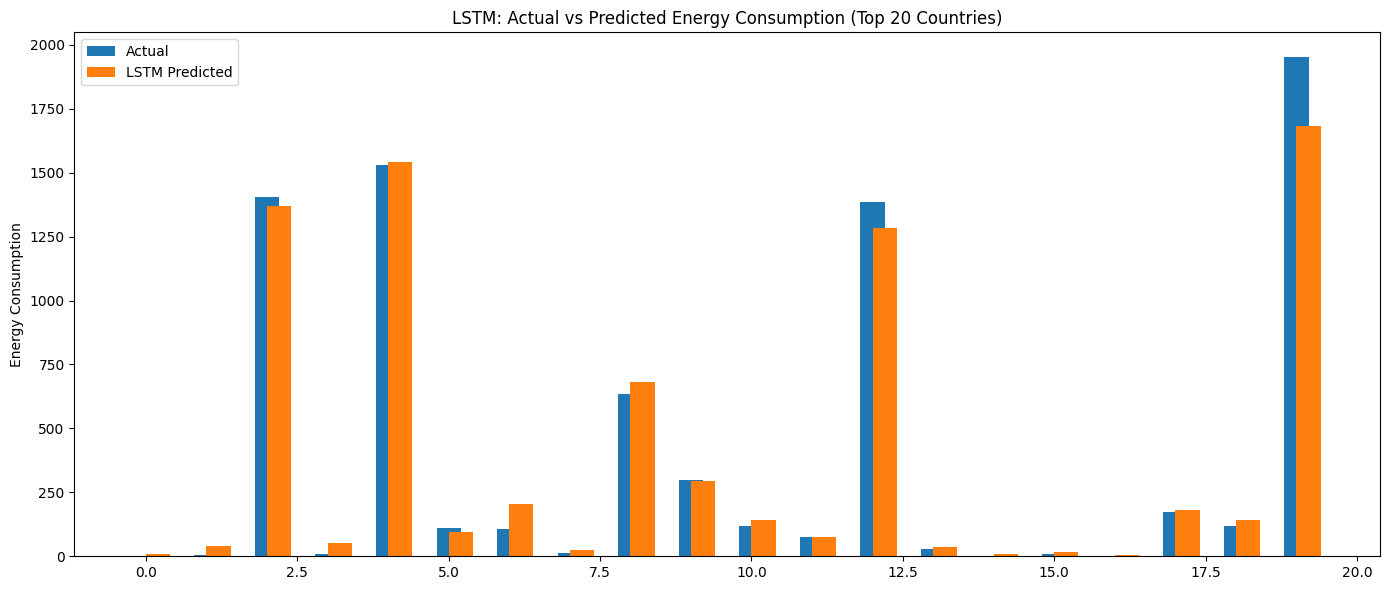


📁 LSTM predictions saved to:
- /content/lstm_energy_predictions.csv


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load and merge datasets
features_df = pd.read_excel('/content/structured_combined_data_train.xlsx')
target_df = pd.read_excel('/content/2021_Energy_data.xlsx')
merged_df = pd.merge(features_df, target_df, on='Country')

# Prepare data
X = merged_df.drop(columns=['Country', '2021_energy_consumption'])
y_raw = merged_df['2021_energy_consumption']

# Normalize the data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Fit a MinMaxScaler on y_raw (energy consumption)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_raw.values.reshape(-1, 1))

# Reshape data to fit LSTM input [samples, time_steps, features]
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])  # Reshape to 3D array for LSTM

# Split data into training and testing (80-20 split)
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions
y_pred_scaled = model.predict(X_test)

# Inverse scaling to get the original values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n🔎 LSTM Model Results")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# Plot Actual vs Predicted for the first 20 countries in the test set
plt.figure(figsize=(14,6))

# Flatten y_test and y_pred to 1D arrays for plotting
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

plt.bar(range(20), y_test_flat[:20], width=0.4, label='Actual', align='center')
plt.bar(range(20), y_pred_flat[:20], width=0.4, label='LSTM Predicted', align='edge')
plt.title('LSTM: Actual vs Predicted Energy Consumption (Top 20 Countries)')
plt.ylabel('Energy Consumption')
plt.legend()
plt.tight_layout()
plt.show()

# Get corresponding countries from the test set
countries_test = merged_df['Country'].values[train_size:]

# Create a DataFrame for results
results_df = pd.DataFrame({
    'Country': countries_test,
    'Actual_2021_Energy_Consumption': y_test_flat,
    'Predicted_2021_Energy_Consumption': y_pred_flat
})

# Save to CSV
results_df.to_csv('/content/lstm_energy_predictions.csv', index=False)


print("\n📁 LSTM predictions saved to:")
print("- /content/lstm_energy_predictions.csv")



**ARIMA model with log transformation**

In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load the merged dataset
df = pd.read_excel('/content/structured_combined_data_train.xlsx')

# Get list of countries
countries = df['Country'].unique()

# Forecast results will be saved here
forecast_results = []

# Define years used for training
years = [str(y) for y in range(2013, 2021)]  # 2013 to 2020

# Loop through each country
for country in countries:
    row = df[df['Country'] == country]

    try:
        # Extract and log-transform target variable
        y_raw = [row[f"{year}_energy_consumption"].values[0] for year in years]
        y_log = np.log1p(y_raw)  # log(1 + x) to avoid log(0) issues
        y = pd.Series(y_log, index=years)

        # Prepare exogenous features
        exog_data = {
            'median': [row[f"{year}_median"].values[0] for year in years],
            'median_masked': [row[f"{year}_median_masked"].values[0] for year in years],
            'minimum': [row[f"{year}_minimum"].values[0] for year in years],
            'maximum': [row[f"{year}_maximum"].values[0] for year in years],
        }
        exog = pd.DataFrame(exog_data, index=years)

        # Fit SARIMAX model
        model = SARIMAX(y, exog=exog, order=(1,1,1))
        model_fit = model.fit(disp=False)

        # Prepare exog for 2021 using last known values (2020)
        last_exog = exog.iloc[-1:].copy()
        last_exog.index = ['2021']

        # Forecast energy consumption for 2021 (log scale)
        forecast_log = model_fit.forecast(steps=1, exog=last_exog)

        # Convert back from log scale
        forecast = np.expm1(forecast_log[0])  # inverse of log1p

        forecast_results.append({'Country': country, 'Forecast_2021': forecast})

    except Exception as e:
        print(f"Error processing {country}: {e}")

# Create DataFrame and save
forecast_df = pd.DataFrame(forecast_results)
forecast_df.to_excel('/content/forecast_energy_2021_log_transformed.xlsx', index=False)

# Display result
print(forecast_df.head())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-14-208fe33044bc>:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = np.expm1(forecast_log[0])  # inverse of log1p
/usr/local/lib/python3.11/dist-packag

       Country  Forecast_2021
0  Afghanistan      27.371975
1      Albania      32.149922
2      Algeria     648.898800
3       Angola     117.907630
4    Argentina     869.828550


<ipython-input-14-208fe33044bc>:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  forecast = np.expm1(forecast_log[0])  # inverse of log1p
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-14-208fe33044bc>:48: F

In [15]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Load actual 2021 energy consumption values
actual_df = pd.read_excel('/content/2021_Energy_data.xlsx')  # Ensure it has 'Country' and '2021_energy_consumption'

# Load forecasted values from SARIMAX (log-transformed model's output)
forecast_df = pd.read_excel('/content/forecast_energy_2021_log_transformed.xlsx')

# Merge actual and forecasted data on Country
merged_df = pd.merge(actual_df[['Country', '2021_energy_consumption']], forecast_df, on='Country')

# Extract actual and predicted values
y_true = merged_df['2021_energy_consumption']
y_pred = merged_df['Forecast_2021']

# Calculate R² and RMSE
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Print results
print(f"R² Score for 2021 Energy Forecast (SARIMAX with Log Transformation): {r2:.4f}")
print(f"RMSE: {rmse:.2f}")


R² Score for 2021 Energy Forecast (SARIMAX with Log Transformation): 0.9969
RMSE: 191.63


In [10]:
!pip install keras-tcn


/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.0138
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0097
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0015
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0149
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0275 
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025    
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0034
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0038
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0155
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0087
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0019    
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0047    
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0061    
E

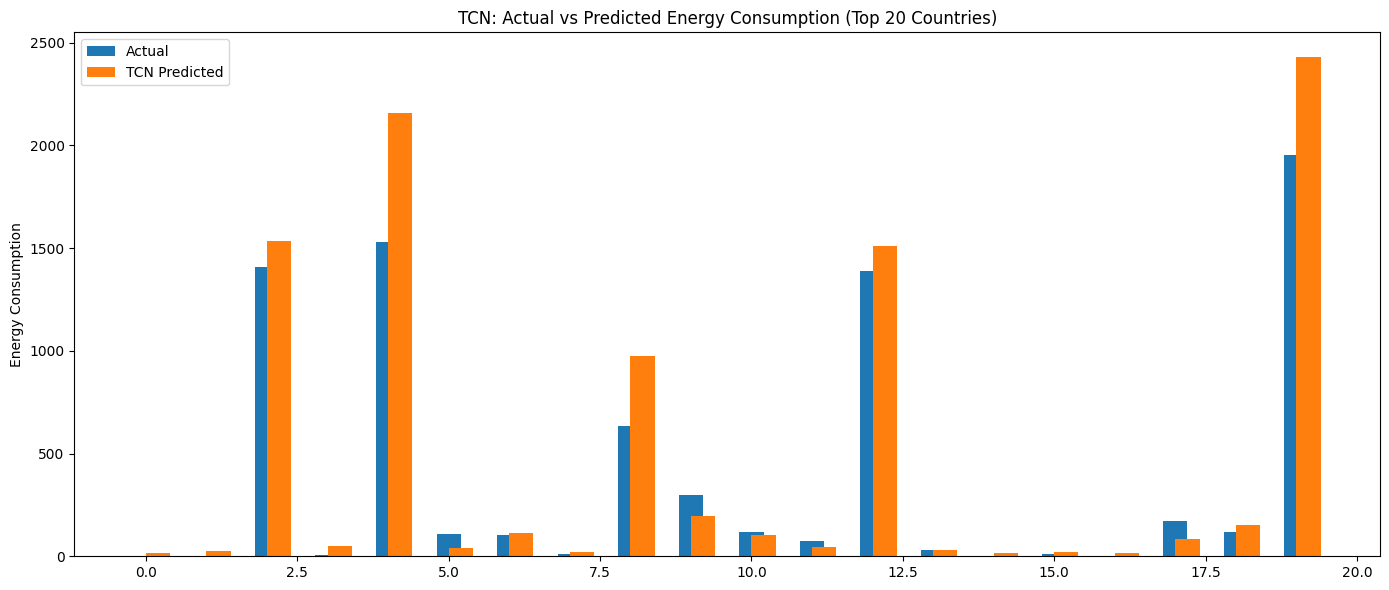


📁 TCN predictions saved to:
- /content/tcn_energy_predictions.csv


In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from tcn import TCN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Load and merge datasets
features_df = pd.read_excel('/content/structured_combined_data_train.xlsx')
target_df = pd.read_excel('/content/2021_Energy_data.xlsx')
merged_df = pd.merge(features_df, target_df, on='Country')

# Prepare data
X = merged_df.drop(columns=['Country', '2021_energy_consumption'])
y_raw = merged_df['2021_energy_consumption']

# Normalize the data
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Fit a MinMaxScaler on y_raw (energy consumption)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_raw.values.reshape(-1, 1))

# Reshape data to fit TCN input [samples, time_steps, features]
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])  # Reshape to 3D array for TCN

# Split data into training and testing (80-20 split)
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# Build TCN model
model = Sequential()
model.add(TCN(input_shape=(X_train.shape[1], X_train.shape[2]), nb_filters=64, kernel_size=3, dilations=[1, 2, 4, 8], dropout_rate=0.2))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the TCN model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)

# Make predictions
y_pred_scaled = model.predict(X_test)

# Inverse scaling to get the original values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("\n🔎 TCN Model Results")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# Plot Actual vs Predicted for the first 20 countries in the test set
plt.figure(figsize=(14,6))

# Flatten y_test and y_pred to 1D arrays for plotting
y_test_flat = y_test.flatten()
y_pred_flat = y_pred.flatten()

plt.bar(range(20), y_test_flat[:20], width=0.4, label='Actual', align='center')
plt.bar(range(20), y_pred_flat[:20], width=0.4, label='TCN Predicted', align='edge')
plt.title('TCN: Actual vs Predicted Energy Consumption (Top 20 Countries)')
plt.ylabel('Energy Consumption')
plt.legend()
plt.tight_layout()
plt.show()

# Get corresponding countries from the test set
countries_test = merged_df['Country'].values[train_size:]

# Create a DataFrame for results
results_df = pd.DataFrame({
    'Country': countries_test,
    'Actual_2021_Energy_Consumption': y_test_flat,
    'Predicted_2021_Energy_Consumption': y_pred_flat
})

# Save to CSV
results_df.to_csv('/content/tcn_energy_predictions.csv', index=False)

print("\n📁 TCN predictions saved to:")
print("- /content/tcn_energy_predictions.csv")


R² Score: 1.0000
RMSE: 19.87


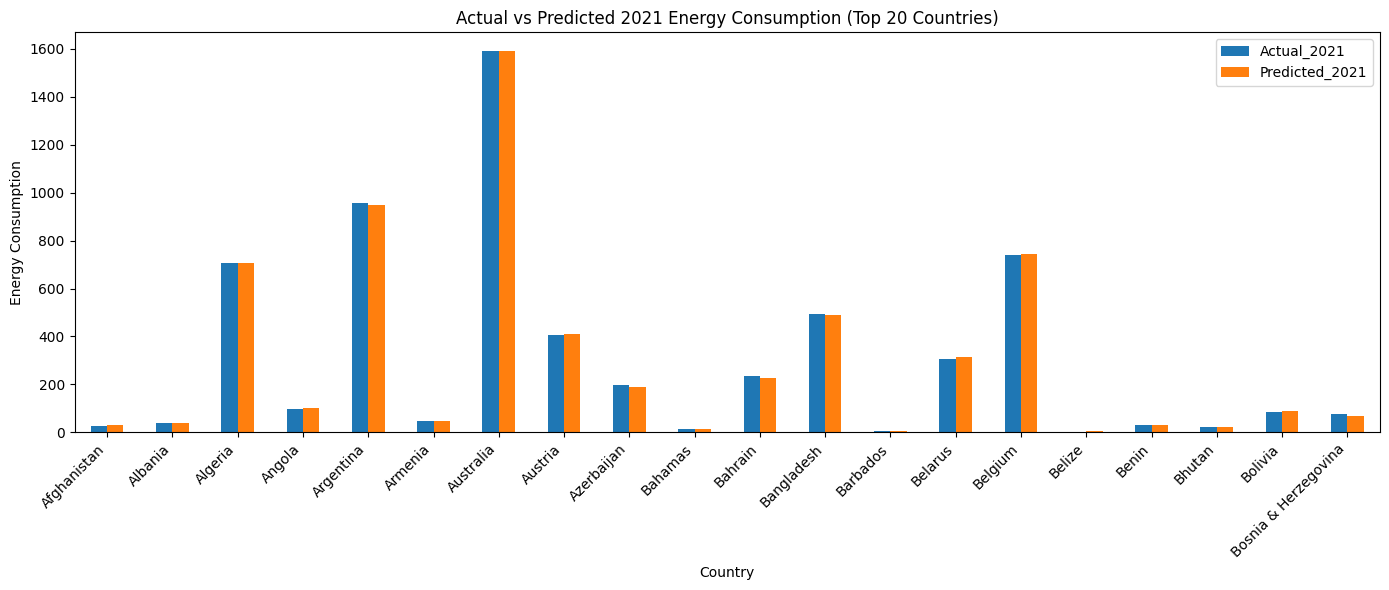

In [16]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load feature dataset (2013–2020 data)
features_df = pd.read_excel('/content/structured_combined_data_train.xlsx')

# Load actual 2021 target values
target_df = pd.read_excel('/content/2021_Energy_data.xlsx')  # contains 'Country' and '2021_energy_consumption'

# Merge both datasets on 'Country'
merged_df = pd.merge(features_df, target_df, on='Country')

# Define feature columns (drop 'Country' and target)
X = merged_df.drop(columns=['Country', '2021_energy_consumption'])
y = merged_df['2021_energy_consumption']

# Train XGBoost Regressor on raw values
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
model.fit(X, y)

# Predict directly
y_pred = model.predict(X)

# Evaluate
r2 = r2_score(y, y_pred)
rmse = mean_squared_error(y, y_pred) ** 0.5

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

# Save predictions with countries
results = pd.DataFrame({
    'Country': merged_df['Country'],
    'Actual_2021': y,
    'Predicted_2021': y_pred
})

results.to_excel('/content/xgboost_energy_2021_predictions_raw.xlsx', index=False)

# Plot actual vs predicted for first 20 countries
results.head(20).plot(x='Country', kind='bar', figsize=(14,6))
plt.title('Actual vs Predicted 2021 Energy Consumption (Top 20 Countries)')
plt.ylabel('Energy Consumption')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
